In [1]:
#Import Stuff
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import xgboost as xgb
import lightgbm as lgb
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.model_selection import cross_val_score, KFold,cross_validate
from sklearn.pipeline import Pipeline
from scipy import stats
from time import time
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.metrics import r2_score,explained_variance_score,mean_squared_error
from sklearn.preprocessing import StandardScaler, RobustScaler
from scipy.stats import norm, skew, randint
from scipy.special import boxcox1p
import os
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras import backend as K
from keras.optimizers import SGD, Adam
import keras.callbacks
from keras.wrappers.scikit_learn import KerasRegressor
from timeit import default_timer as timer
import warnings
warnings.filterwarnings('ignore')

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Data Preparation

In [7]:
#Check out the format of data scrapped
cwd = os.getcwd()
datadir = cwd+'/58/'

f=open(datadir + 'chongming_58.txt')
X=f.readline()
X[:3000]

"[[[['房屋户型\\n2室1厅1卫', '房本面积\\n45㎡', '房屋朝向\\n南北', '所在楼层\\n共5层', '装修情况\\n简单装修\\n\\n\\n找装修', '产权年限\\n70年', '建筑年代\\n2000年'], ['小区均价\\n9748.0元/㎡\\n\\n                                            环比上月\\xa0\\n                                        0.02%', '所在商圈\\n\\n\\n                                            崇明\\n                                        －\\n                                        \\n                                            陈家', '物业费\\n\\n                                                                                    0.60元/平米·月', '容积率\\n0.00', '绿化率\\n0.00', '在售房源\\n\\n\\n                                                1套在租\\n                                            \\n\\n\\n\\n                                                167套在售']], '36万', '8000元/㎡'], [[['房屋户型\\n2室2厅1卫', '房本面积\\n75㎡', '房屋朝向\\n南北', '所在楼层\\n低层/共6层', '装修情况\\n精装修\\n\\n\\n找装修', '产权年限\\n70年', '建筑年代\\n2015年'], ['小区均价\\n10852.0元/㎡\\n\\n                                            环比上月\\xa0\\n            

In [60]:
#Since it is really messy, we build a function to get the format right and put it into a data frame

def getdataframe(x):
    f=open(x)
    list1,list2,list3,list4,list5,list6=[],[],[],[],[],[]
    for line in f:
        list1.append(line)
    list1=list1[0].split('\\n')#split the text into lists and strip all unnecessary symbol and space
    for i in list1:
        if i.strip(" '[]")!='':
            list2.append(i.strip("' []").strip())
    for i in list2:
        list3.append(i.split(','))
    list4=[]
    for i in list3:
        if len(i)==1:
            list4.append(i[0])
        else:
            for j in i:
                list4.append(j)
    for i in list4:
        if i !='－' and i!='.':
            list5.append(i.strip(" '[]"))
    j=-1
    for i in list5: #build a list containing lists each indicating the information of a unit on sale
        if i =='房屋户型':
            j+=1
            list6.append([])
            list6[j].append(i)
        else:
            list6[j].append(i)
    featurelist=['房屋户型','房本面积','房屋朝向','所在楼层','装修情况','产权年限','建筑年代','小区均价','环比上月\\xa0','所在商圈','物业费','容积率','绿化率']
    dict1={}
    for i in featurelist:
        dict1[i]=[]
        dict1['总价']=[]
        dict1['每平价格']=[]
    for i in list6:
        if all(x in i for x in featurelist): #transfer the list into a dict
            dict1['总价'].append(i[-2])
            dict1['每平价格'].append(i[-1])
            for j in i[:-2]:
                if j in featurelist:
                    label=j
                    i=0
                else:
                    if i==0:
                        dict1[label].append(j)
                        i+=1
    df=pd.DataFrame(dict1)#get the dataframe
    return(df)


In [61]:
# concat the dataframe of each district
name = ['baoshan_58.txt','changning_58.txt','chongming_58.txt','fengxiansh_58.txt','hongkou_58.txt','huangpu_58.txt','jiading_58.txt','jingan_58.txt','jinshan_58.txt','luwan_58.txt','minxing_58.txt','pudongxinqu_58.txt','putuo_58.txt','qingpu_58.txt','songjiang_58.txt','xuhui_58.txt','yangpu_58.txt']
df_total = getdataframe(datadir+'zhabei_58.txt')
for i in name:
    df = getdataframe(datadir+str(i))
    df_total=pd.concat([df_total,df])

In [62]:
df_total.shape

(47159, 15)

In [63]:
df_total.head(10)

,房屋户型,总价,每平价格,房本面积,房屋朝向,所在楼层,装修情况,产权年限,建筑年代,小区均价,环比上月\xa0,所在商圈,物业费,容积率,绿化率
0,2室2厅1卫,790万,89772元/㎡,88㎡,南,低层/共32层,豪华装修,70年,2011年,92101.0元/㎡,-0.7%,闸北,4.00元/平米·月,3.75,45.00
1,3室2厅3卫,1650万,88709元/㎡,186㎡,南,高层/共29层,豪华装修,70年,2018年,100356.0元/㎡,-0.94%,闸北,4.80元/平米·月,3.00,40.00
2,2室0厅1卫,315万,60576元/㎡,52㎡,南,中层/共6层,简单装修,70年,1988年,61045.0元/㎡,-0.29%,闸北,0.60元/平米/月元/平米·月,0.00,23.00
3,2室1厅1卫,345万,59156元/㎡,58.32㎡,南,低层/共28层,精装修,70年,2003年,70488.0元/㎡,-1.09%,闸北,1.10元/平米/月元/平米·月,2.20,41.00
4,2室0厅1卫,315万,65502元/㎡,48.09㎡,南,中层/共6层,简单装修,70年,1988年,63545.0元/㎡,-1.24%,闸北,0.55元/平米/月元/平米·月,0.00,38.00
5,2室2厅1卫,705万,75741元/㎡,93.08㎡,南北,低层/共6层,精装修,70年,2006年,79085.0元/㎡,1.87%,闸北,1.50元/平米/月元/平米·月,2.30,35.00
6,2室2厅1卫,406万,56388元/㎡,72㎡,南北,低层/共6层,精装修,70年,2001年,65569.0元/㎡,1.18%,闸北,0.65元/平米·月,1.36,37.00
7,3室2厅2卫,900万,75592元/㎡,119.06㎡,南北,高层/共17层,精装修,70年,2006年,79085.0元/㎡,1.87%,闸北,1.50元/平米/月元/平米·月,2.30,35.00
8,2室1厅1卫,205万,44219元/㎡,46.36㎡,南北,共4层,精装修,70年,1994年,49564.0元/㎡,-2.05%,闸北,0.55元/平米/月元/平米·月,0.00,35.00
9,2室2厅1卫,430万,51970元/㎡,82.74㎡,南,中层/共28层,精装修,70年,2014年,56232.0元/㎡,-2.11%,闸北,1.20元/平米/月元/平米·月,0.00,35.00


In [64]:
#Change the column name
df_total.rename(index=str,columns={'总价':'Total Price','每平价格':'Price Per Square Meter','房屋户型':'Housing Unit','房本面积':'Usable Area','房屋朝向':'Orientation','所在楼层':'Floor Number','装修情况':'House Remodeling','产权年限':'Duration of Property Right','建筑年代':'Year of Construction','小区均价':'Average Price of the community','环比上月\\xa0':'Month-on-Month Growth Rate','所在商圈':'District','物业费':'Property Management Fee','容积率':'Floor Area Ration','绿化率':'Green Space Ratio'},inplace=True)
df_total.head(5)

,Housing Unit,Total Price,Price Per Square Meter,Usable Area,Orientation,Floor Number,House Remodeling,Duration of Property Right,Year of Construction,Average Price of the community,Month-on-Month Growth Rate,District,Property Management Fee,Floor Area Ration,Green Space Ratio
0,2室2厅1卫,790万,89772元/㎡,88㎡,南,低层/共32层,豪华装修,70年,2011年,92101.0元/㎡,-0.7%,闸北,4.00元/平米·月,3.75,45.00
1,3室2厅3卫,1650万,88709元/㎡,186㎡,南,高层/共29层,豪华装修,70年,2018年,100356.0元/㎡,-0.94%,闸北,4.80元/平米·月,3.00,40.00
2,2室0厅1卫,315万,60576元/㎡,52㎡,南,中层/共6层,简单装修,70年,1988年,61045.0元/㎡,-0.29%,闸北,0.60元/平米/月元/平米·月,0.00,23.00
3,2室1厅1卫,345万,59156元/㎡,58.32㎡,南,低层/共28层,精装修,70年,2003年,70488.0元/㎡,-1.09%,闸北,1.10元/平米/月元/平米·月,2.20,41.00
4,2室0厅1卫,315万,65502元/㎡,48.09㎡,南,中层/共6层,简单装修,70年,1988年,63545.0元/㎡,-1.24%,闸北,0.55元/平米/月元/平米·月,0.00,38.00


# Data Cleaning

In [65]:
# defining function strip_unit to get rid of the units from the raw data and transfer string to numerical information
# The function returns the dataframe with a new column of cleaned data added 
def strip_units(data, col, n, new_col):
    new_list = []
    for i in data[col]:
        new_list.append(float(i[:-n]))
    data[new_col] = new_list
    return data

# call the strip_units function for the eight columns that need to have their units removed

for i in ['Total Price', 'Usable Area', 'Duration of Property Right', 'Year of Construction', 'Month-on-Month Growth Rate']:
    df_total = strip_units(df_total, i, 1, i+' new')
for i in ['Price Per Square Meter', 'Average Price of the community']:
    df_total = strip_units(df_total, i, 3, i+' new')

# Extract the information about number of rooms for the property from the originial string crawled from website
# Creating column 'housing_unit' which has each element as a list in the form of [bedroom no., dining room no., bathroom no.]
# Creating column of 'bedroom' 'dining' and 'bathroom' to store seperate digit information for training

housing_unit = []
bedroom = []
dining = []
bathroom = []
for i in df_total['Housing Unit']:
    total = [int(j) for j in i if j.isdigit()]
    housing_unit.append(total)
    bedroom.append(total[0])
    dining.append(total[1])
    bathroom.append(total[2])
df_total['bedroom'] = bedroom
df_total['dining'] = dining
df_total['bathroom'] = bathroom
df_total['Housing Unit new'] = housing_unit

# transfer the column of 'Orientation', 'House Modelling', and 'District' into catagorical features
# store a dict and reverse dict for the each category and their indices

orientation_list = list(df_total.groupby(['Orientation']).groups.keys())
orientation_dict = {orientation_list[i]:i for i in range(len(orientation_list))}
orientation_rev_dict = {i:orientation_list[i] for i in range(len(orientation_list))}
orientation_new = []
for i in df_total['Orientation']:
    orientation_new.append(orientation_dict[i])
df_total['Orientation new'] = orientation_new

remodelling_list = list(df_total.groupby(['House Remodeling']).groups.keys())
remodelling_dict = {remodelling_list[i]:i for i in range(len(remodelling_list))}
remodelling_rev_dict = {i:remodelling_list[i] for i in range(len(remodelling_list))}
remodelling_new = []
for i in df_total['House Remodeling']:
    remodelling_new.append(remodelling_dict[i])
df_total['House Remodeling new'] = remodelling_new

District_list = list(df_total.groupby(['District']).groups.keys())
District_dict = {District_list[i]:i for i in range(len(District_list))}
District_rev_dict = {i:District_list[i] for i in range(len(District_list))}
District_new = []
for i in df_total['District']:
    District_new.append(District_dict[i])
df_total['District new'] = District_new

# Split the information from 'Floor Number' column into two columns of 'floor position' and 'total floor'
# Catagorize the 'floor position' feature
# Transfer 'total floor' feature into integers
floor_position = []
total_floor = []
position_list = ['高层', '中层', '低层', '地下']
position_dict = {position_list[i]:i for i in range(len(position_list))}
for i in df_total['Floor Number']:
    splitted = i.split('/')
    try:
        a = splitted[1][1:-1]
        total_floor.append(int(splitted[1][1:-1]))
        floor_position.append(int(position_dict[splitted[0]]))
    except IndexError:
        floor_position.append(None)
        total_floor.append(int(splitted[0][1:-1]))
df_total['floor position'] = floor_position
df_total['total floor'] = total_floor

# Extract the numeric value for 'management fee' 
management_fee = []
for i in df_total['Property Management Fee']:
    try: management_fee.append(float(i[:4]))
    except ValueError: management_fee.append(None)
df_total['Property Management Fee new'] = management_fee

# Transfer string into numeric data
df_total['Floor Area Ratio']=pd.to_numeric(df_total['Floor Area Ration'])
df_total['Green Space Ratio']=pd.to_numeric(df_total['Green Space Ratio'])

# create a new dataframe df_new with all features transfered into numerical form
df_new = df_total.iloc[:,-19:]
df_new.head(10)


,Green Space Ratio,Total Price new,Usable Area new,Duration of Property Right new,Year of Construction new,Month-on-Month Growth Rate new,Price Per Square Meter new,Average Price of the community new,bedroom,dining,bathroom,Housing Unit new,Orientation new,House Remodeling new,District new,floor position,total floor,Property Management Fee new,Floor Area Ratio
0,45.0,790.0,88.00,70.0,2011.0,-0.70,89772.0,92101.0,2,2,1,"[2, 2, 1]",5,4,14,2.0,32,4.00,3.75
1,40.0,1650.0,186.00,70.0,2018.0,-0.94,88709.0,100356.0,3,2,3,"[3, 2, 3]",5,4,14,0.0,29,4.80,3.00
2,23.0,315.0,52.00,70.0,1988.0,-0.29,60576.0,61045.0,2,0,1,"[2, 0, 1]",5,2,14,1.0,6,0.60,0.00
3,41.0,345.0,58.32,70.0,2003.0,-1.09,59156.0,70488.0,2,1,1,"[2, 1, 1]",5,3,14,2.0,28,1.10,2.20
4,38.0,315.0,48.09,70.0,1988.0,-1.24,65502.0,63545.0,2,0,1,"[2, 0, 1]",5,2,14,1.0,6,0.55,0.00
5,35.0,705.0,93.08,70.0,2006.0,1.87,75741.0,79085.0,2,2,1,"[2, 2, 1]",6,3,14,2.0,6,1.50,2.30
6,37.0,406.0,72.00,70.0,2001.0,1.18,56388.0,65569.0,2,2,1,"[2, 2, 1]",6,3,14,2.0,6,0.65,1.36
7,35.0,900.0,119.06,70.0,2006.0,1.87,75592.0,79085.0,3,2,2,"[3, 2, 2]",6,3,14,0.0,17,1.50,2.30
8,35.0,205.0,46.36,70.0,1994.0,-2.05,44219.0,49564.0,2,1,1,"[2, 1, 1]",6,3,14,NaN,4,0.55,0.00
9,35.0,430.0,82.74,70.0,2014.0,-2.11,51970.0,56232.0,2,2,1,"[2, 2, 1]",5,3,14,1.0,28,1.20,0.00


In [66]:
print('Orientation dict:{}'.format(orientation_dict)+'\n')
print('District dict:{}'.format(District_dict)+'\n')
print('Remodelling dict{}'.format(remodelling_dict)+'\n')
print('Position dict{}'.format(position_dict)+'\n')

Orientation dict:{'东': 0, '东北': 1, '东南': 2, '东西': 3, '北': 4, '南': 5, '南北': 6, '西': 7, '西北': 8, '西南': 9}

District dict:{'卢湾': 0, '嘉定': 1, '奉贤': 2, '宝山': 3, '崇明': 4, '徐汇': 5, '普陀': 6, '杨浦': 7, '松江': 8, '浦东': 9, '虹口': 10, '金山': 11, '长宁': 12, '闵行': 13, '闸北': 14, '青浦': 15, '静安': 16, '黄浦': 17}

Remodelling dict{'中等装修': 0, '毛坯': 1, '简单装修': 2, '精装修': 3, '豪华装修': 4}

Position dict{'高层': 0, '中层': 1, '低层': 2, '地下': 3}



In [68]:
# Check and drop duplicates

# Due to the mechanism of search engine embedded in the target website, there exists some duplicates in the data frame
# This module will detect and remove all these duplicates
df_new['converted_housing_unit'] = df_new['Housing Unit new'].apply(lambda x: str(x))
df_new.drop('Housing Unit new',axis=1,inplace=True)
print(df_new.shape)
a=df_new.shape[0]
df_new.drop_duplicates(inplace=True)
print(df_new.shape)
print('{} duplicates removed'.format(a-df_new.shape[0]))

(47159, 19)
(31623, 19)
15536 duplicates removed


In [11]:
# Check out missing values
df_new.shape[0] - df_new.count()

Green Space Ratio                        0
Total Price new                          0
Usable Area new                          0
Duration of Property Right new           0
Year of Construction new                 0
Month-on-Month Growth Rate new           0
Price Per Square Meter new               0
Average Price of the community new       0
bedroom                                  0
dining                                   0
bathroom                                 0
Housing Unit new                         0
Orientation new                          0
House Remodeling new                     0
District new                             0
floor position                        2551
total floor                              0
Property Management Fee new              4
Floor Area Ratio                         0
dtype: int64

In [12]:
# for feature 'floor position' we can see that all missing value is because the number of total floors is too low to define floor position, so we fill in all missing value with category 2: low floors
df_new['floor position'] = df_new['floor position'].fillna(value=2)

# we drop the four instances with missing values in 'Property Management Fee new' columns
df_new.dropna(subset=['Property Management Fee new'], inplace = True)

In [13]:
df_new.shape[0] - df_new.count()

Green Space Ratio                     0
Total Price new                       0
Usable Area new                       0
Duration of Property Right new        0
Year of Construction new              0
Month-on-Month Growth Rate new        0
Price Per Square Meter new            0
Average Price of the community new    0
bedroom                               0
dining                                0
bathroom                              0
Housing Unit new                      0
Orientation new                       0
House Remodeling new                  0
District new                          0
floor position                        0
total floor                           0
Property Management Fee new           0
Floor Area Ratio                      0
dtype: int64

# Exploratory Analysis

In [14]:
df_new.describe()

,Green Space Ratio,Total Price new,Usable Area new,Duration of Property Right new,Year of Construction new,Month-on-Month Growth Rate new,Price Per Square Meter new,Average Price of the community new,bedroom,dining,bathroom,Orientation new,House Remodeling new,District new,floor position,total floor,Property Management Fee new,Floor Area Ratio
count,31619.000000,31619.000000,31619.000000,31619.000000,31619.000000,31619.000000,31619.000000,31619.000000,31619.000000,31619.000000,31619.000000,31619.000000,31619.000000,31619.000000,31619.000000,31619.000000,31619.000000,31619.000000
mean,28.512349,318.796166,73.666803,68.702679,2005.796325,1.214632,38521.561498,41810.315633,2.134666,1.581106,1.245928,5.516904,2.795661,7.676682,1.063474,11.376135,1.457345,1.321957
std,15.934891,653.810115,57.506262,5.392976,11.749338,5.625831,25154.937860,26681.983777,0.789996,0.579467,0.609237,0.802963,0.676236,4.497403,0.708639,6.940326,8.427115,1.108385
min,0.000000,7.000000,10.000000,40.000000,1900.000000,-34.150000,2592.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,25.000000,85.500000,44.000000,70.000000,2000.000000,-1.440000,17777.000000,20072.000000,2.000000,1.000000,1.000000,5.000000,3.000000,4.000000,1.000000,6.000000,0.550000,0.000000
50%,35.000000,215.000000,61.600000,70.000000,2010.000000,-0.030000,33333.000000,37372.000000,2.000000,2.000000,1.000000,6.000000,3.000000,8.000000,1.000000,10.000000,1.000000,1.400000
75%,38.000000,380.000000,89.270000,70.000000,2014.000000,2.500000,54287.500000,58665.000000,2.000000,2.000000,1.000000,6.000000,3.000000,11.000000,2.000000,16.000000,1.600000,2.000000
max,235.000000,46500.000000,2000.000000,70.000000,2021.000000,39.890000,287214.000000,353630.000000,9.000000,9.000000,9.000000,9.000000,4.000000,17.000000,3.000000,76.000000,1045.000000,8.800000


{'东': 0, '东北': 1, '东南': 2, '东西': 3, '北': 4, '南': 5, '南北': 6, '西': 7, '西北': 8, '西南': 9}


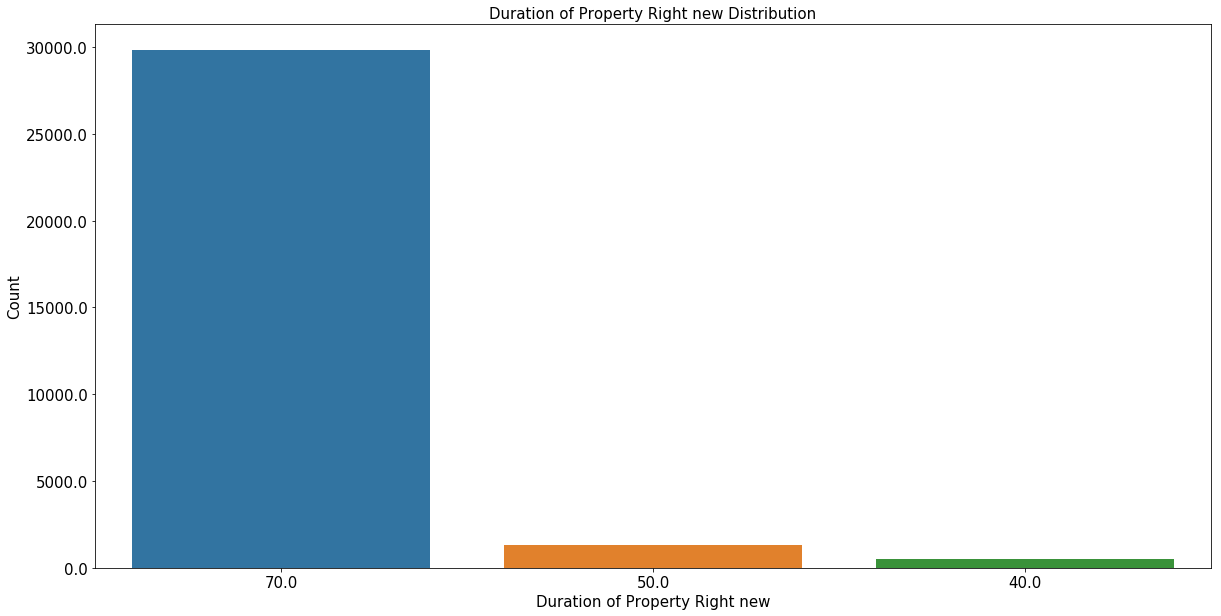

In [15]:
#Check out the distribution of Duration of Property Right new
plt.figure(figsize=(20,10))
p = sns.countplot(x = 'Duration of Property Right new',data = df_new,order = df_new['Duration of Property Right new'].value_counts().index)
p.set_title("Duration of Property Right new Distribution", fontsize=15)
p.set_xlabel("Duration of Property Right new", fontsize=15)
p.set_ylabel("Count", fontsize=15)
p.set_xticklabels(p.get_xticklabels(),fontsize=15)
p.set_yticklabels(p.get_yticks(),fontsize=15)
print(orientation_dict)

plt.show()

{'东': 0, '东北': 1, '东南': 2, '东西': 3, '北': 4, '南': 5, '南北': 6, '西': 7, '西北': 8, '西南': 9}


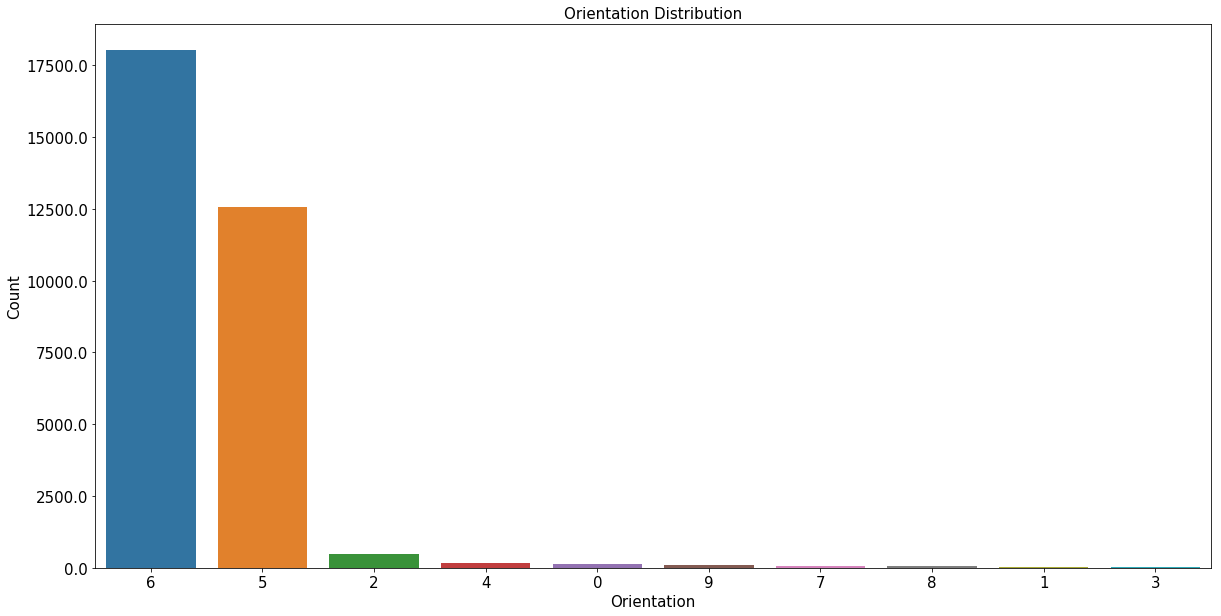

In [16]:
#Check out the distribution of Orientation
plt.figure(figsize=(20,10))
p = sns.countplot(x = 'Orientation new',data = df_new,order = df_new['Orientation new'].value_counts().index)
p.set_title("Orientation Distribution", fontsize=15)
p.set_xlabel("Orientation", fontsize=15)
p.set_ylabel("Count", fontsize=15)
p.set_xticklabels(p.get_xticklabels(),fontsize=15)

p.set_yticklabels(p.get_yticks(),fontsize=15)
print(orientation_dict)

plt.show()

{'卢湾': 0, '嘉定': 1, '奉贤': 2, '宝山': 3, '崇明': 4, '徐汇': 5, '普陀': 6, '杨浦': 7, '松江': 8, '浦东': 9, '虹口': 10, '金山': 11, '长宁': 12, '闵行': 13, '闸北': 14, '青浦': 15, '静安': 16, '黄浦': 17}


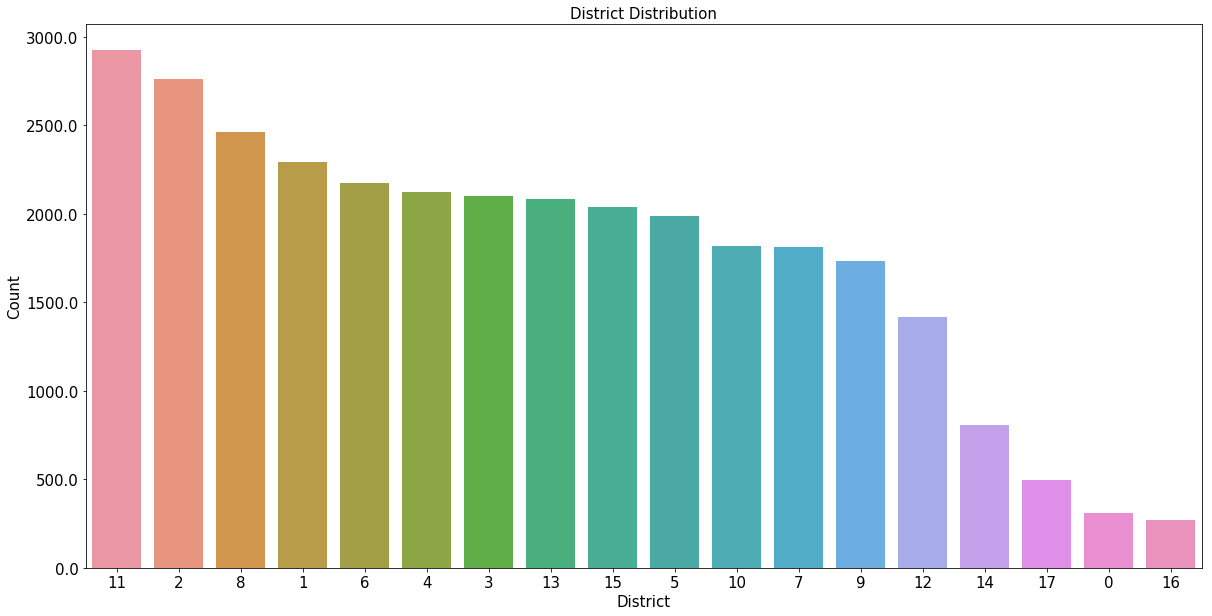

In [17]:
#Check out the distribution of District
plt.figure(figsize=(20,10))

p = sns.countplot(x = 'District new',data = df_new,order = df_new['District new'].value_counts().index)
p.set_title("District Distribution", fontsize=15)
p.set_xlabel("District", fontsize=15)
p.set_ylabel("Count", fontsize=15)
p.set_xticklabels(p.get_xticklabels(),fontsize=15)
p.set_yticklabels(p.get_yticks(),fontsize=15)
print(District_dict)

plt.show()

{'中等装修': 0, '毛坯': 1, '简单装修': 2, '精装修': 3, '豪华装修': 4}


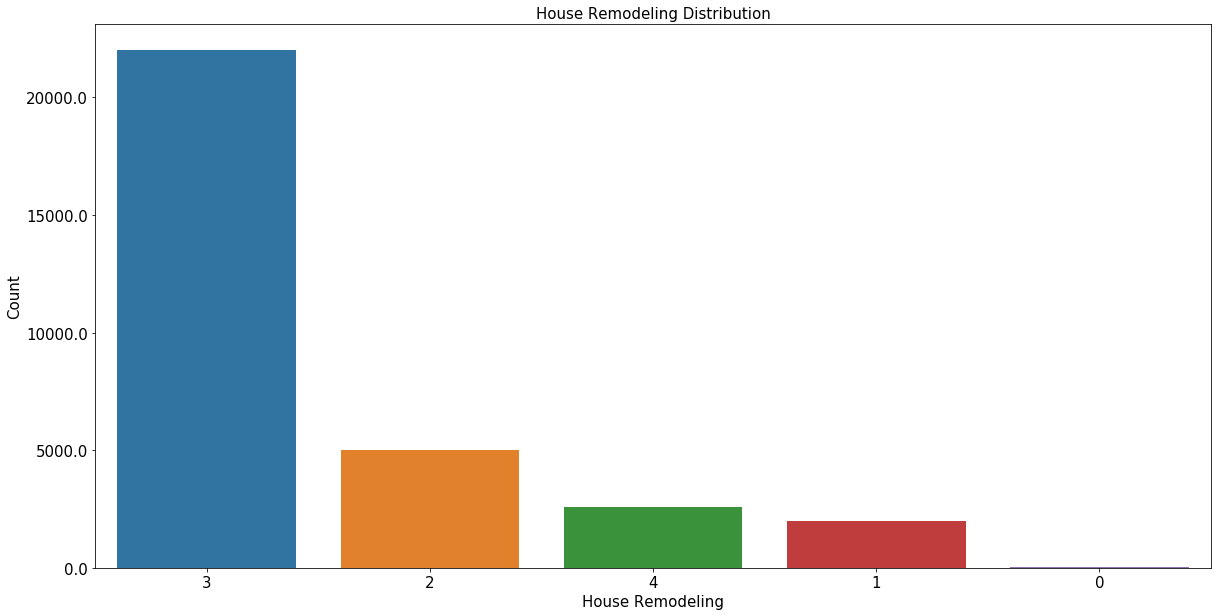

In [18]:
#Check out the distribution of Remodeling situation

plt.figure(figsize=(20,10))
p = sns.countplot(x = 'House Remodeling new',data = df_new,order = df_new['House Remodeling new'].value_counts().index)
p.set_title("House Remodeling Distribution", fontsize=15)
p.set_xlabel("House Remodeling", fontsize=15)
p.set_ylabel("Count", fontsize=15)
p.set_xticklabels(p.get_xticklabels(),fontsize=15)
p.set_yticklabels(p.get_yticks(),fontsize=15)
print(remodelling_dict)

plt.show()

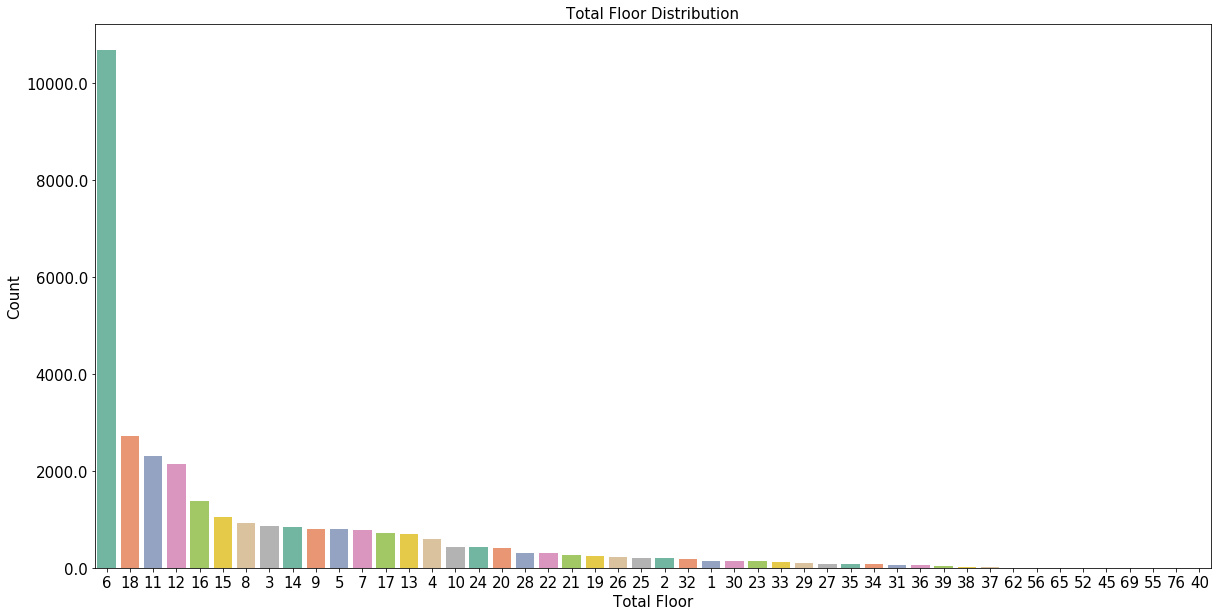

In [19]:
#Check out the distribution of Total floor
plt.figure(figsize=(20,10))

p = sns.countplot(x = 'total floor',data = df_new,order = df_new['total floor'].value_counts().index,palette='Set2')
p.set_title("Total Floor Distribution", fontsize=15)
p.set_xlabel("Total Floor", fontsize=15)
p.set_ylabel("Count", fontsize=15)
p.set_xticklabels(p.get_xticklabels(),fontsize=15)
p.set_yticklabels(p.get_yticks(),fontsize=15)

plt.show()

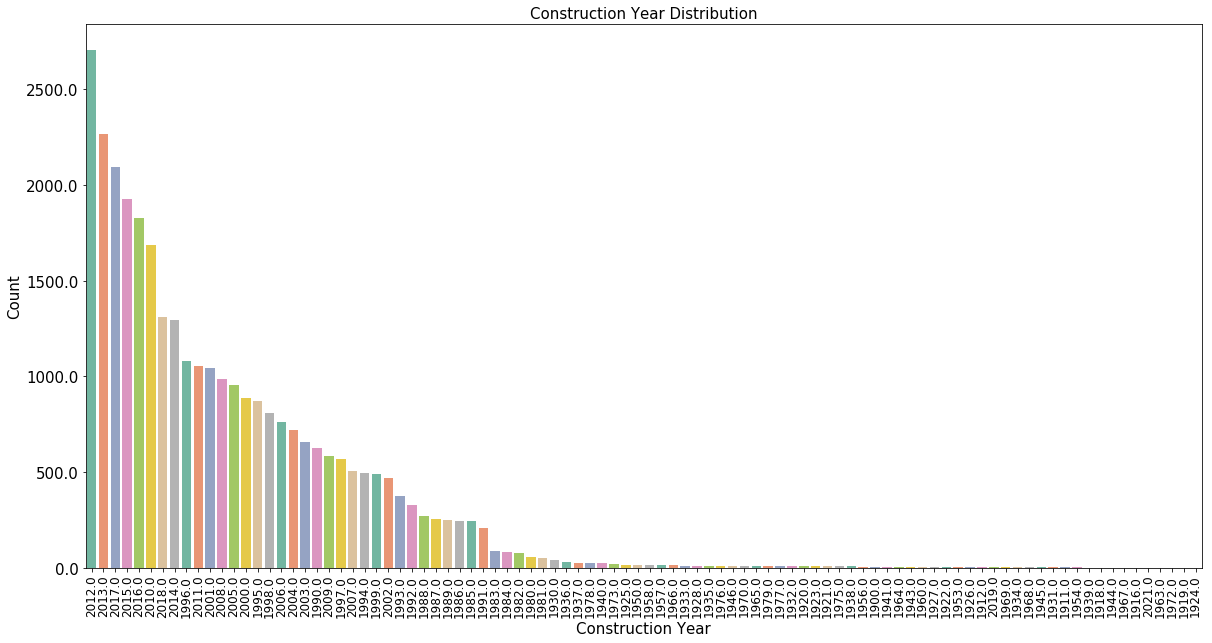

In [20]:
#Check out the distribution of Construction year
plt.figure(figsize=(20,10))

p = sns.countplot(x = df_new['Year of Construction new'],data = df_new,order = df_new['Year of Construction new'].value_counts().index,palette='Set2')
p.set_title("Construction Year Distribution", fontsize=15)
p.set_xlabel("Construction Year", fontsize=15)
p.set_ylabel("Count", fontsize=15)
p.set_xticklabels(p.get_xticklabels(),fontsize=12,rotation=90)
p.set_yticklabels(p.get_yticks(),fontsize=15)
plt.tight_layout
plt.show()

Text(0,0.5,'Frequency Distribuition')

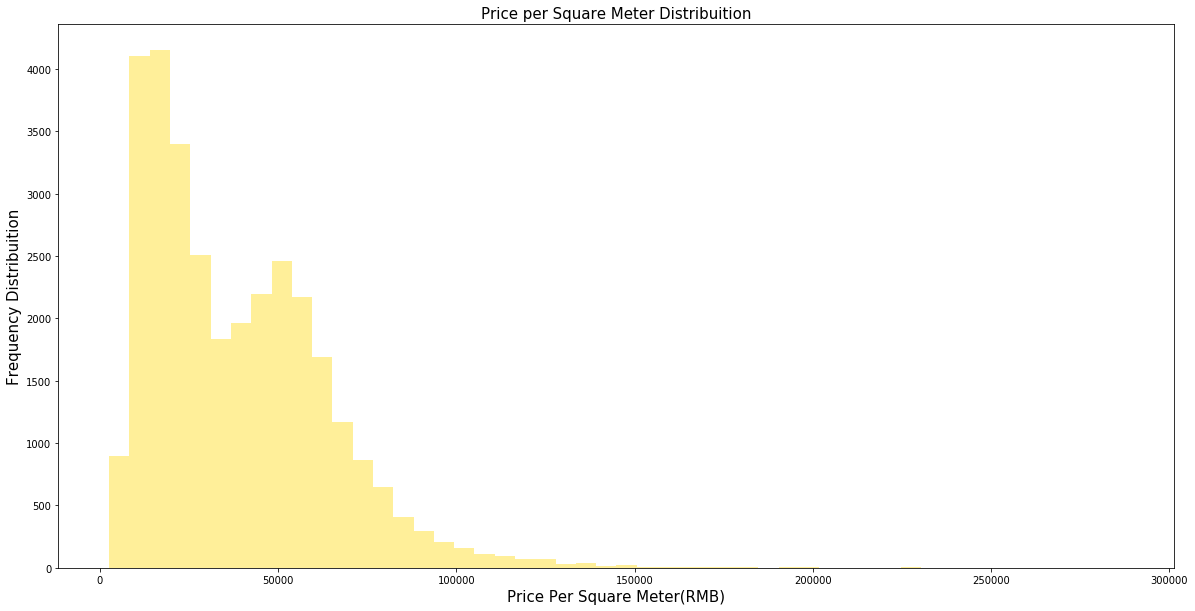

In [21]:
#Check out the distribution of Price per Square Meter
plt.figure(figsize=(20,10))
p = sns.distplot(df_new['Price Per Square Meter new'],color='gold',kde=False)
p.set_title("Price per Square Meter Distribuition", fontsize=15)
p.set_xlabel("Price Per Square Meter(RMB)", fontsize=15)
p.set_ylabel("Frequency Distribuition", fontsize=15)

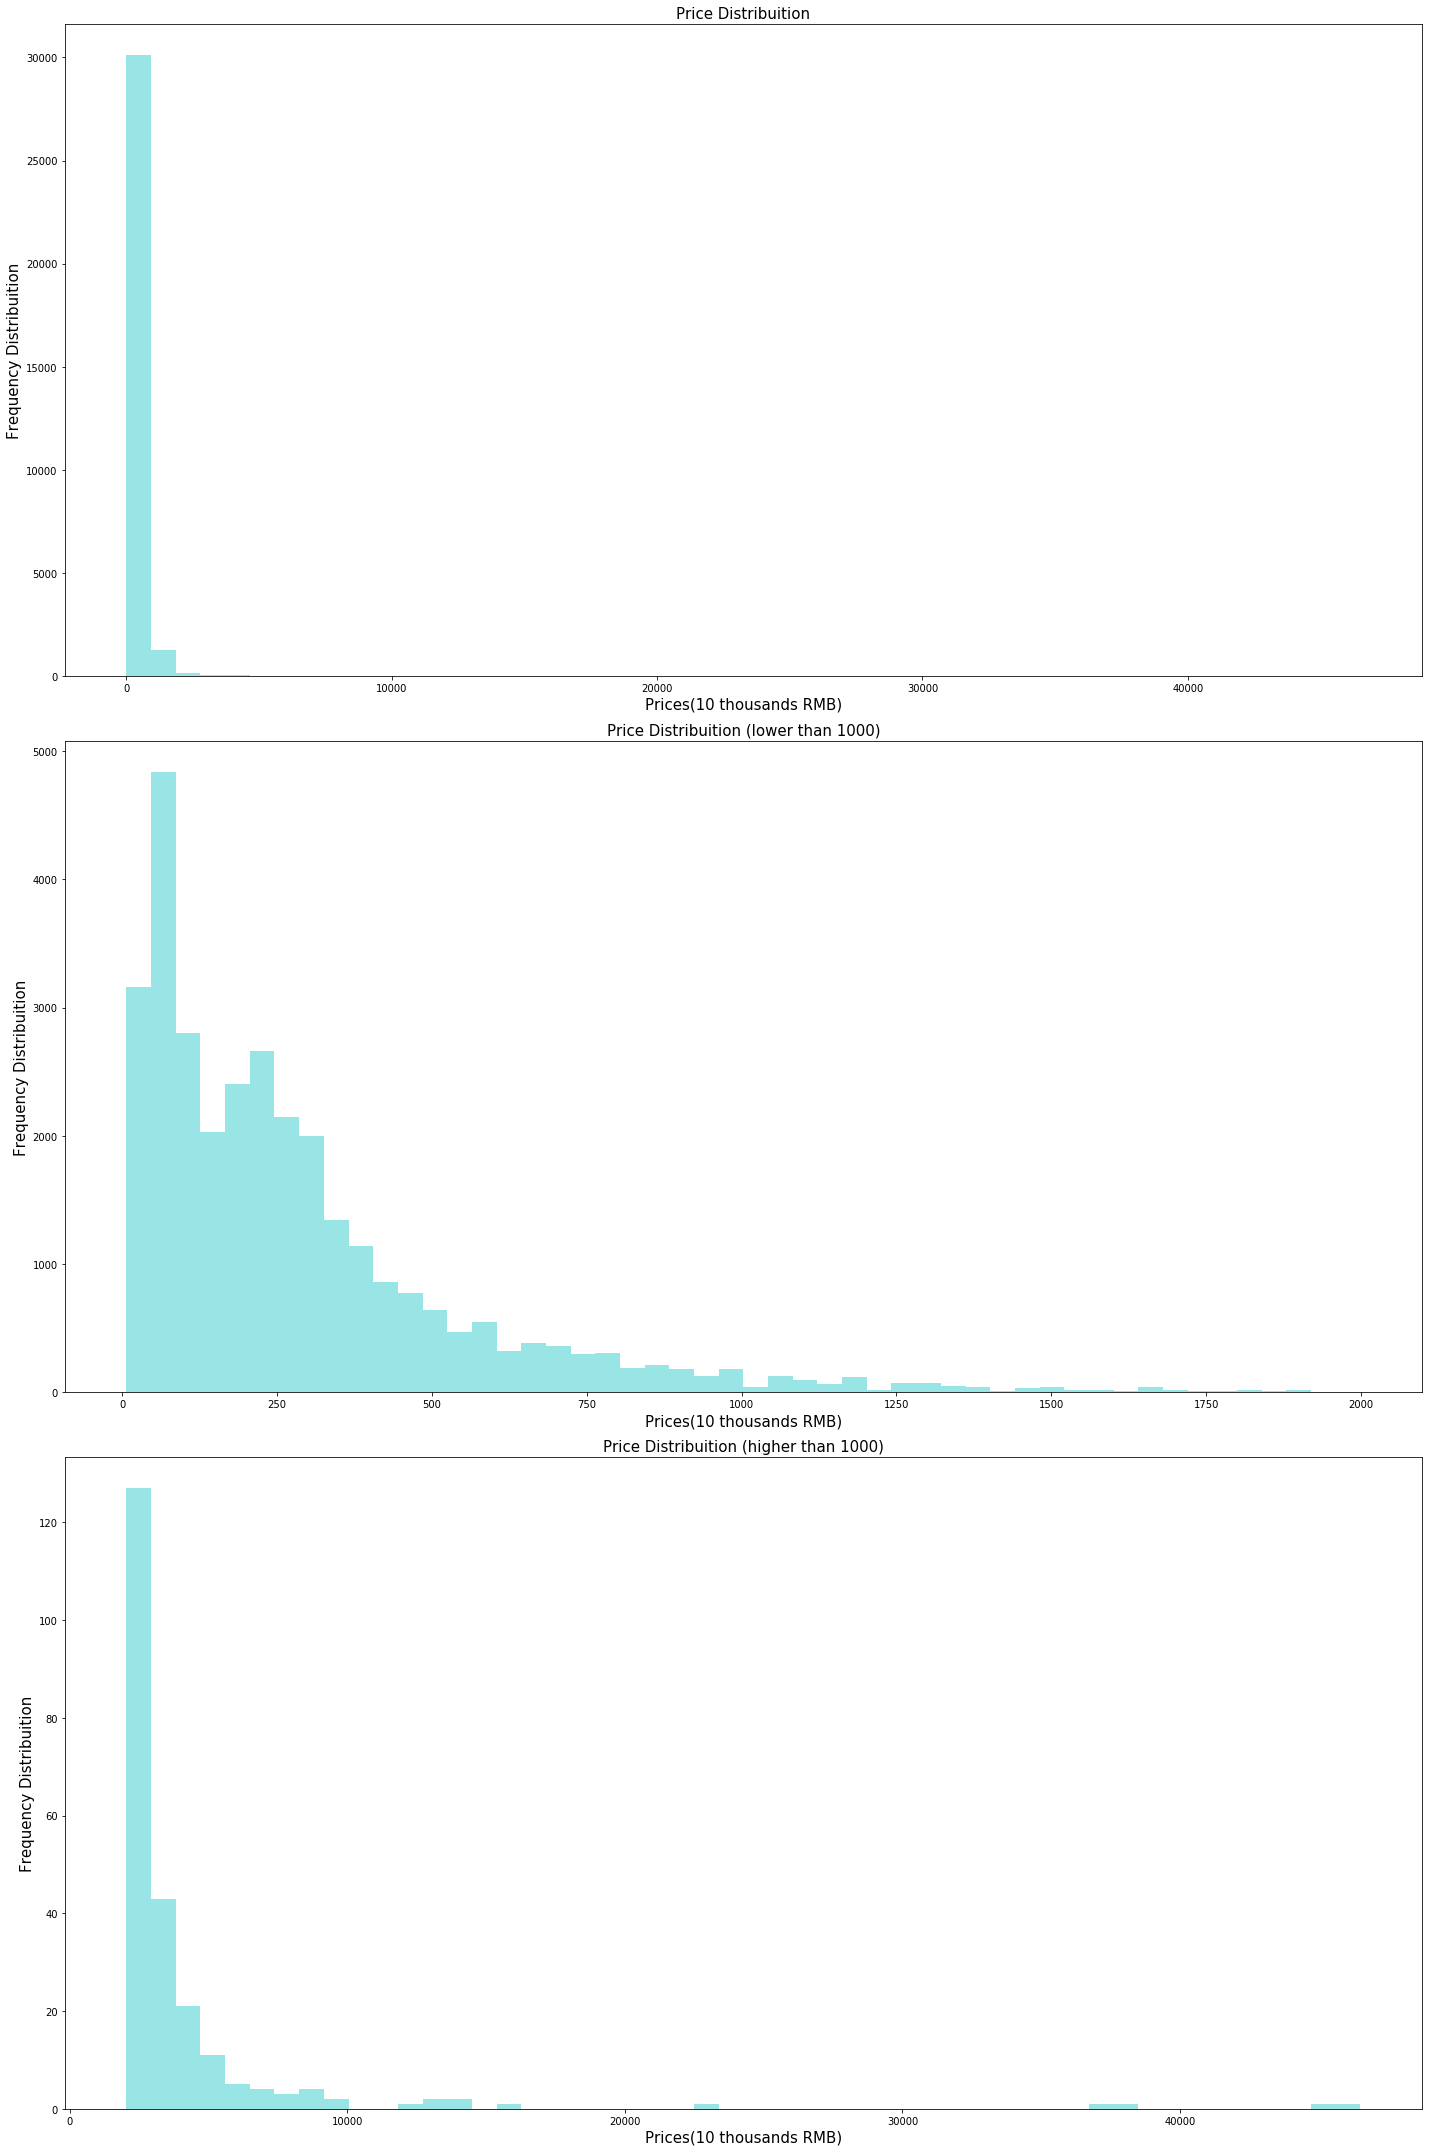

In [22]:
#Check out the distribution of Total Price

plt.figure(figsize=(20,30))
p = plt.subplot(311)
p = sns.distplot(df_new['Total Price new'],color='c',kde=False)
p.set_title("Price Distribuition", fontsize=15)
p.set_xlabel("Prices(10 thousands RMB)", fontsize=15)
p.set_ylabel("Frequency Distribuition", fontsize=15)

p = plt.subplot(312)
p = sns.distplot(df_new[df_new['Total Price new'] < 2000]['Total Price new'],color='c',kde=False)
p.set_title("Price Distribuition (lower than 1000)", fontsize=15)
p.set_xlabel("Prices(10 thousands RMB)", fontsize=15)
p.set_ylabel("Frequency Distribuition", fontsize=15)

p = plt.subplot(313)
p = sns.distplot(df_new[df_new['Total Price new'] > 2000]['Total Price new'],color='c',kde=False)
p.set_title("Price Distribuition (higher than 1000)", fontsize=15)
p.set_xlabel("Prices(10 thousands RMB)", fontsize=15)
p.set_ylabel("Frequency Distribuition", fontsize=15)
plt.tight_layout()
plt.show()


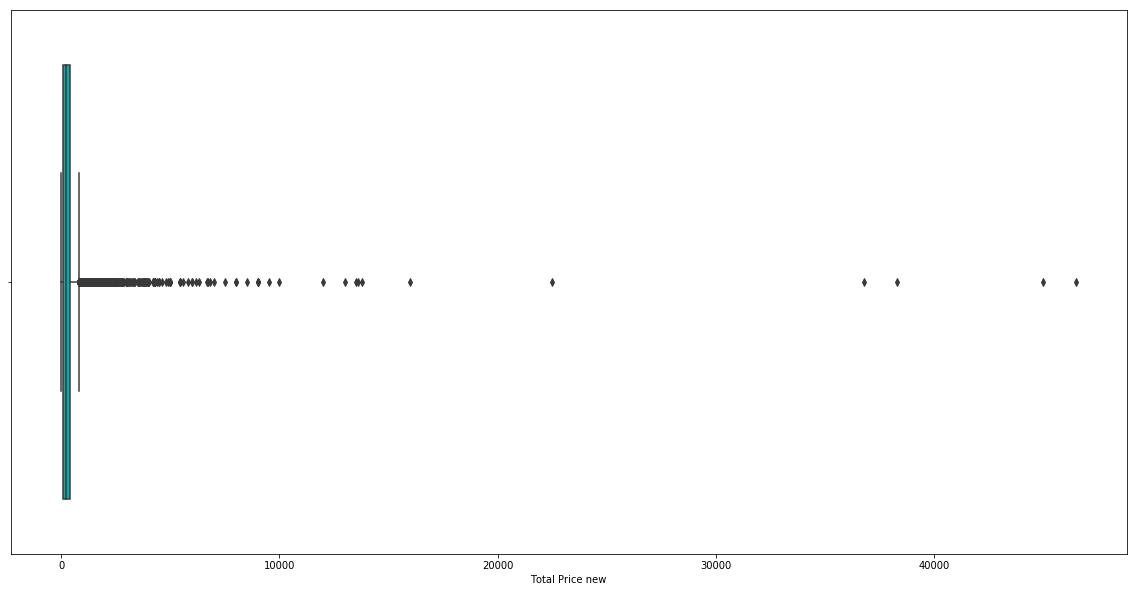

In [23]:
plt.figure(figsize=(20,10))
sns.boxplot(df_new['Total Price new'],color='c')

Text(0,0.5,'Frequency Distribuition')

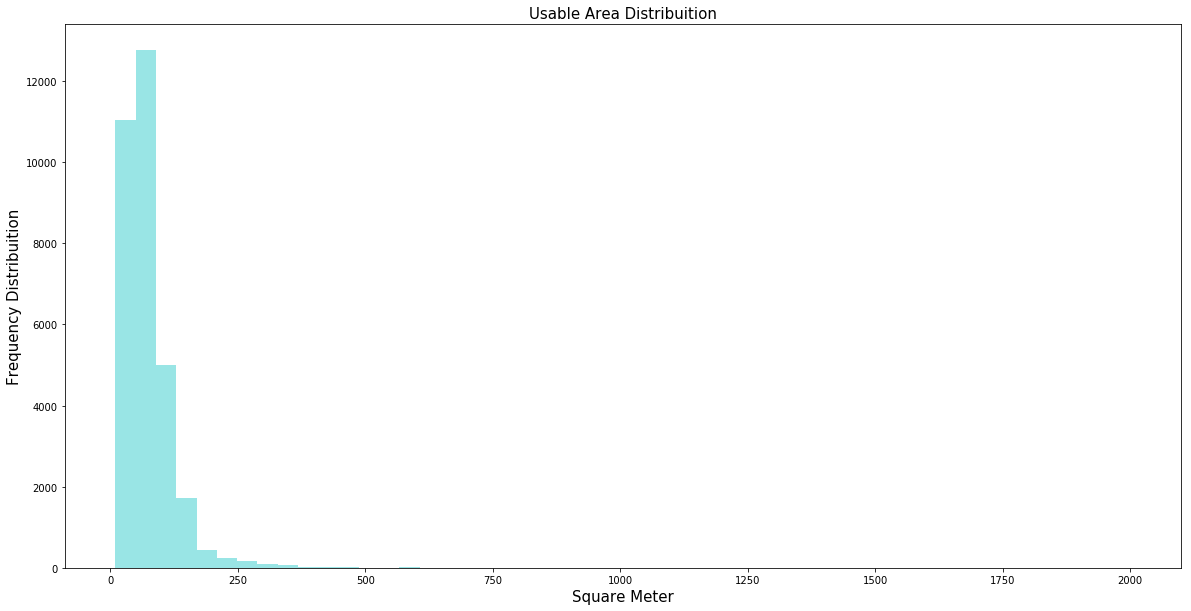

In [24]:
#Check out the distribution of Usable Area

plt.figure(figsize=(20,10))
p = sns.distplot(df_new['Usable Area new'],color='c',kde=False)
p.set_title("Usable Area Distribuition", fontsize=15)
p.set_xlabel("Square Meter", fontsize=15)
p.set_ylabel("Frequency Distribuition", fontsize=15)

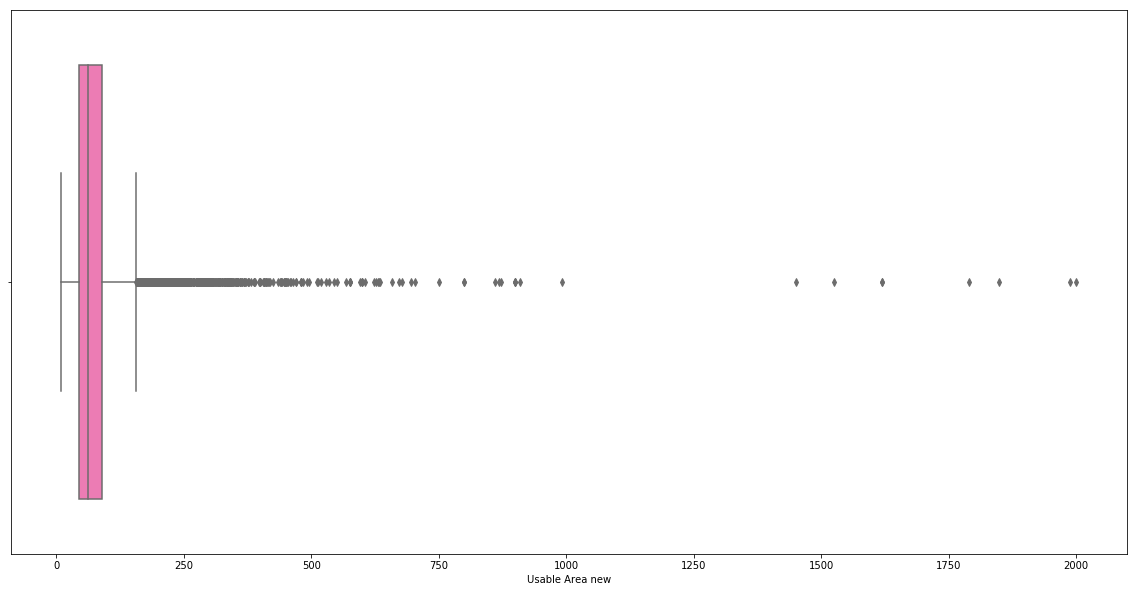

In [25]:
plt.figure(figsize=(20,10))
sns.boxplot(df_new['Usable Area new'],color='hotpink')

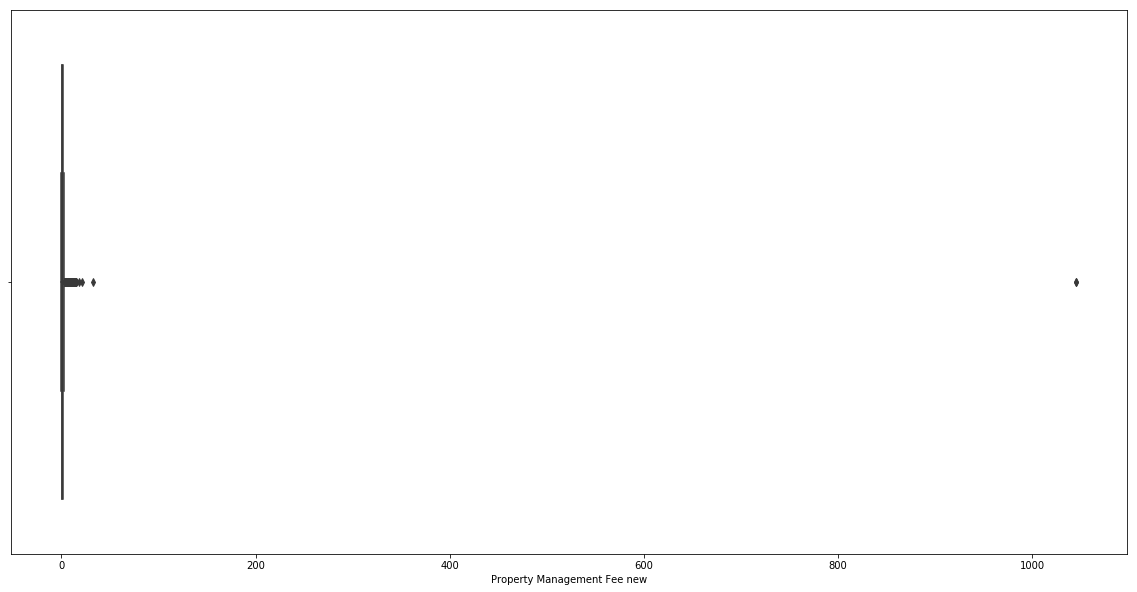

In [26]:
plt.figure(figsize=(20,10))
sns.boxplot(df_new['Property Management Fee new'],color='c')

In [27]:
corr=df_new.corr()

[Text(0,0.5,'Green Space Ratio'),
 Text(0,1.5,'Total Price new'),
 Text(0,2.5,'Usable Area new'),
 Text(0,3.5,'Duration of Property Right new'),
 Text(0,4.5,'Year of Construction new'),
 Text(0,5.5,'Month-on-Month Growth Rate new'),
 Text(0,6.5,'Price Per Square Meter new'),
 Text(0,7.5,'Average Price of the community new'),
 Text(0,8.5,'bedroom'),
 Text(0,9.5,'dining'),
 Text(0,10.5,'bathroom'),
 Text(0,11.5,'Orientation new'),
 Text(0,12.5,'House Remodeling new'),
 Text(0,13.5,'District new'),
 Text(0,14.5,'floor position'),
 Text(0,15.5,'total floor'),
 Text(0,16.5,'Property Management Fee new'),
 Text(0,17.5,'Floor Area Ratio')]

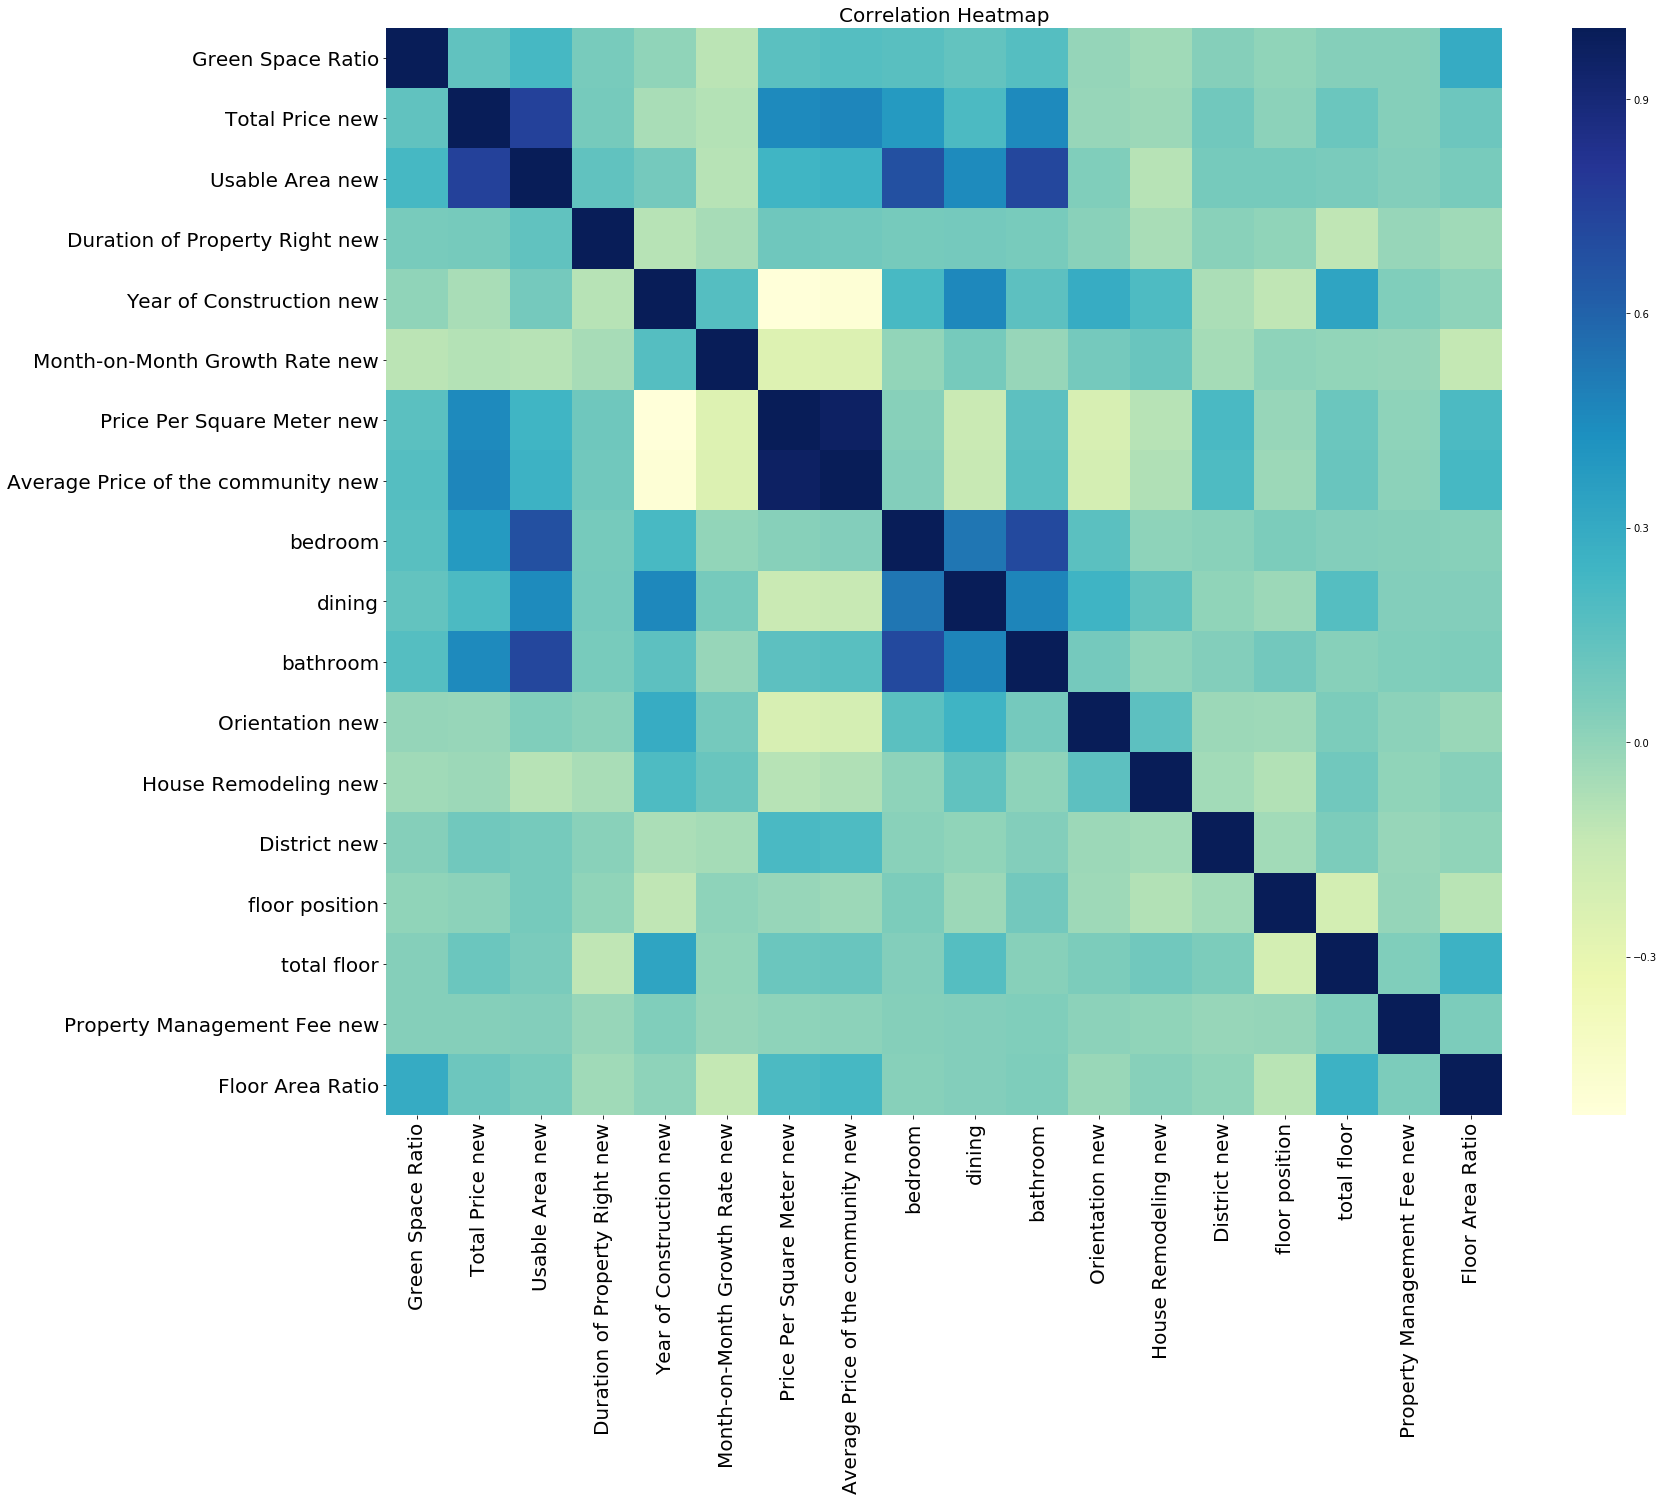

In [28]:
#Check out the Correlation Headmap
plt.figure(figsize=(25,20))
p = sns.heatmap(corr, cmap="YlGnBu")
p.set_title('Correlation Heatmap', fontsize=20)
p.set_xticklabels(p.get_xticklabels(),fontsize=20)
p.set_yticklabels(p.get_yticklabels(),fontsize=20)

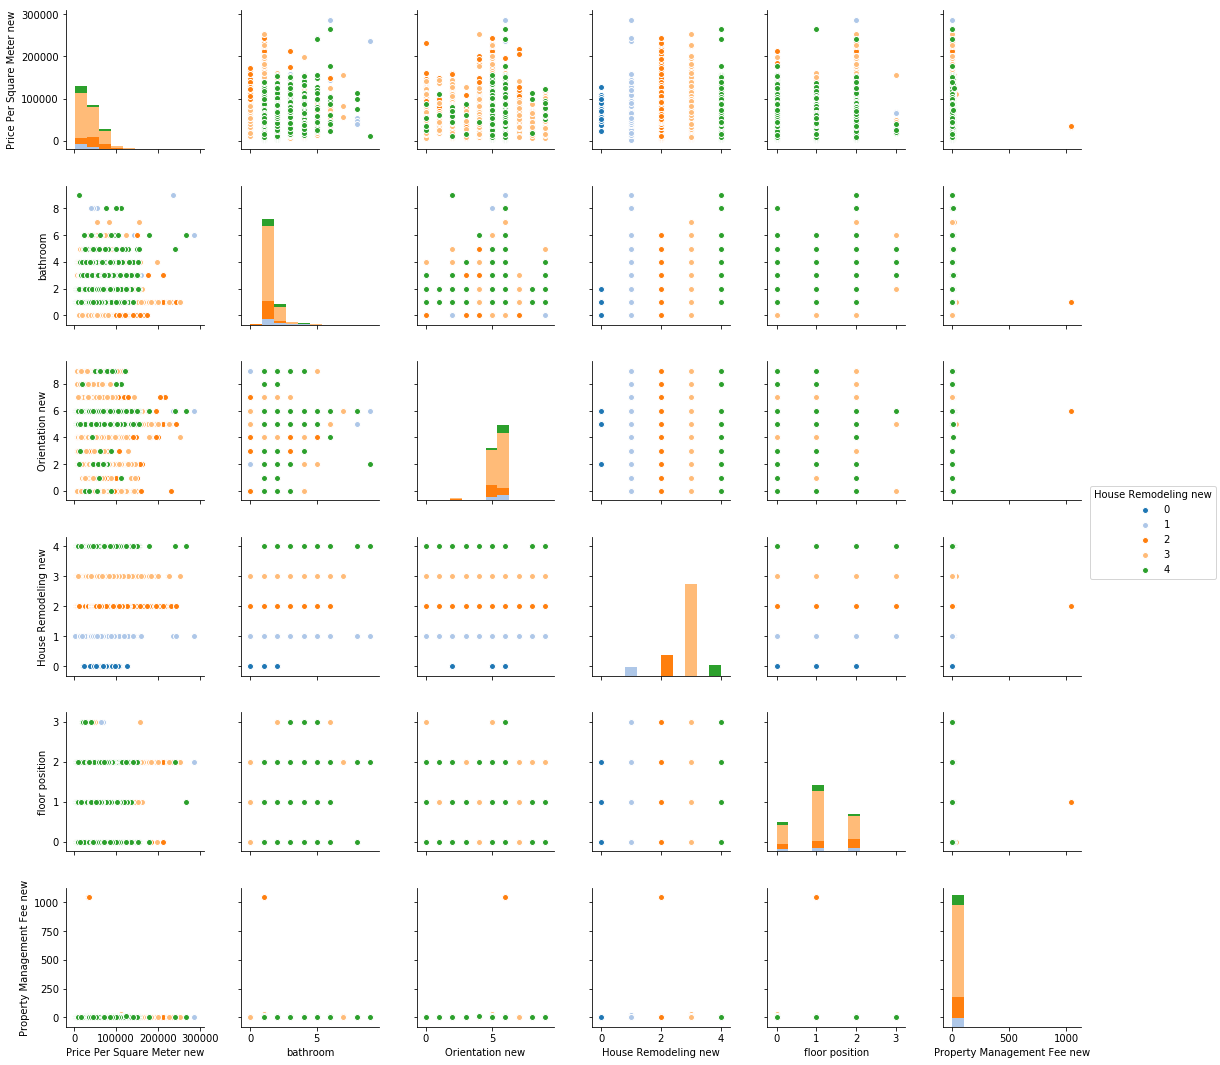

In [29]:
#Check out the pairplot among:
#Usable Area, Price Per Square Meter, Orientation, Floor Position, House remodeling situation, and Property Management Fee
sns.pairplot(df_new.iloc[:,[6,10,12,13,15,17]],hue='House Remodeling new',palette='tab20')

# Feature Enigneering

In [30]:
#Remove Outliers
#We decided to delete these some outliers as they are very huge and can affect the performance of model
#There are still outliers in the training data. However, removing all them may affect the models if ever there were also outliers in the test data. 
#Instead of removing them all, we will make our models robust on them.
x=df_new.shape[0]-df_new[df_new['Total Price new']<11000].shape[0]
print('number of instances removed:{}'.format(x))

number of instances removed:11


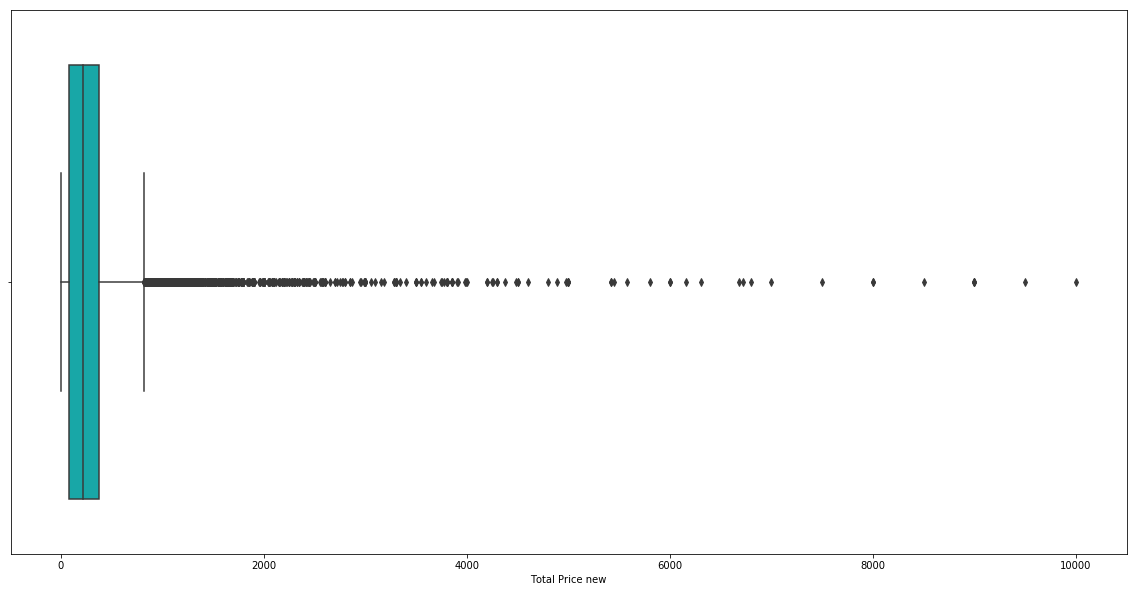

In [31]:
#Check the distribution after removing some extrem outliers
plt.figure(figsize=(20,10))
sns.boxplot(df_new[df_new['Total Price new']<11000]['Total Price new'],color='c')

number of instances removed:8


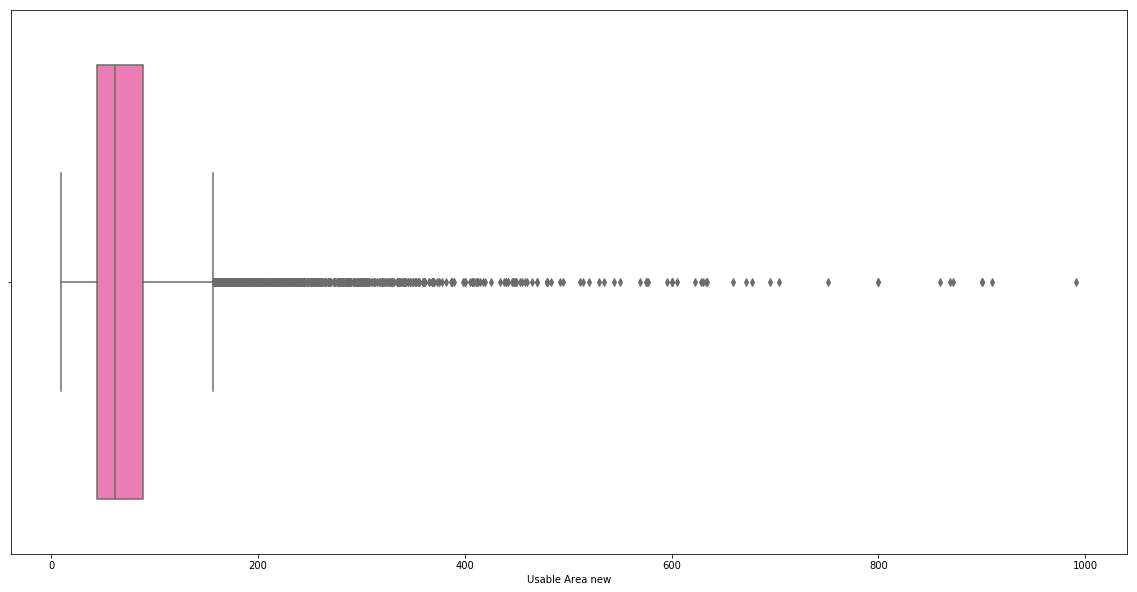

In [32]:
#Check the distribution after removing some extrem outliers
x=df_new.shape[0]-df_new[df_new['Usable Area new']<1200].shape[0]
print('number of instances removed:{}'.format(x))
plt.figure(figsize=(20,10))
sns.boxplot(df_new[df_new['Usable Area new']<1200]['Usable Area new'],color='hotpink')

number of instances removed:5


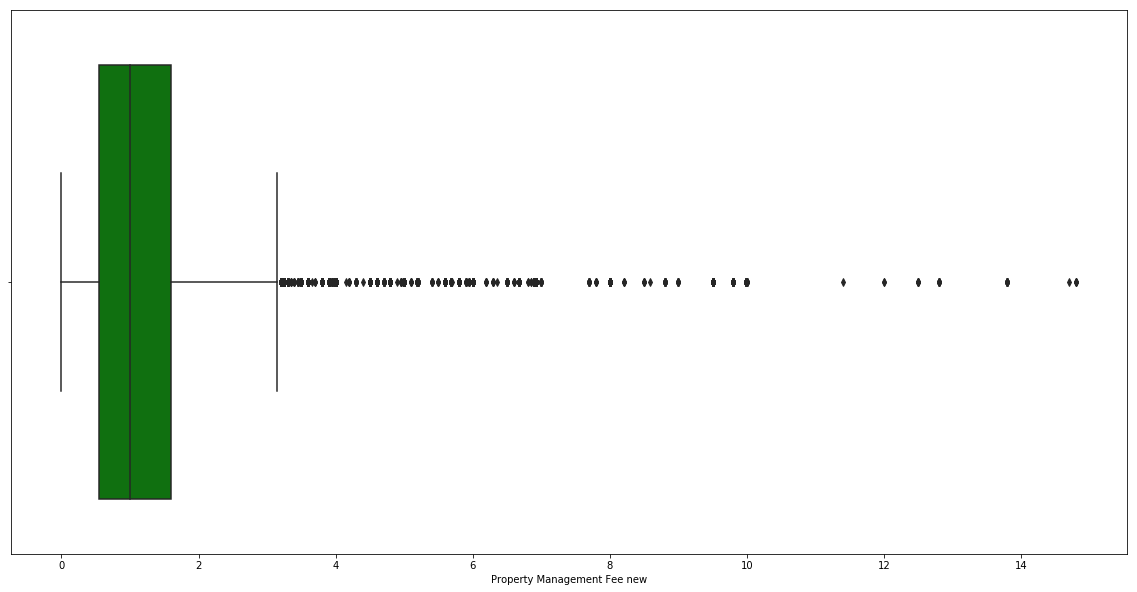

In [33]:
#Check the distribution after removing some extrem outliers
x=df_new.shape[0]-df_new[df_new['Property Management Fee new']<17].shape[0]
print('number of instances removed:{}'.format(x))
plt.figure(figsize=(20,10))
sns.boxplot(df_new[df_new['Property Management Fee new']<17]['Property Management Fee new'],color='g')

In [35]:
df_new=df_new[df_new['Property Management Fee new']<17]
df_new=df_new[df_new['Total Price new']<11000]
df_new=df_new[df_new['Usable Area new']<1200]
print('Total instance removed: {}'.format(31623-df_new.shape[0]))

Total instance removed: 21


In [36]:
# Check the skewness of Numeric Features
# First get rid off categorical features and features that causes leakage 
df_new1=df_new.drop(['Price Per Square Meter new','Average Price of the community new','Housing Unit new','Orientation new','District new','Month-on-Month Growth Rate new'],axis=1)
numeric_feat = df_new1.dtypes[df_new1.dtypes != "object"].index
skewed_feat = df_new1[numeric_feat].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewed_feat})
skewness#Return the skewness of each feature

,Skew
Total Price new,6.817607
Usable Area new,3.982487
bathroom,3.110918
Property Management Fee new,2.837423
bedroom,1.313551
total floor,1.311342
Green Space Ratio,0.815148
Floor Area Ratio,0.719754
floor position,-0.065616
dining,-0.201142


In [37]:
#Use Box Cox transformation to reduce the skewness of most skewed features
skewness = skewness[abs(skewness) > 1]
skewed_index = skewness.index
lam = 0.15
for featurename in skewed_index:
    df_new[featurename] = boxcox1p(df_new[featurename], lam)

Text(0,0.5,'Frequency Distribuition')

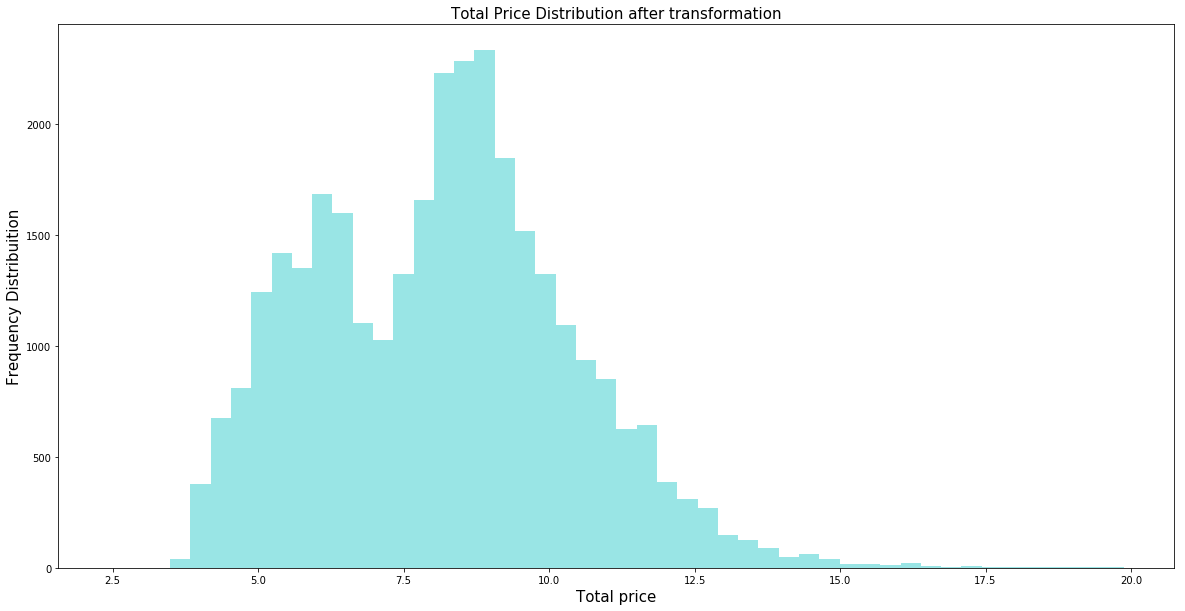

In [38]:
#Check the distribution of Label after transformation
plt.figure(figsize=(20,10))
p = sns.distplot(df_new['Total Price new'],color='c',kde=False)
p.set_title("Total Price Distribution after transformation", fontsize=15)
p.set_xlabel("Total price", fontsize=15)
p.set_ylabel("Frequency Distribuition", fontsize=15)

In [39]:
# drop column of 'Price Per Square Meter new' since it involves leak for our prediction
# drop the 'housing unit' feature as the information is involved in other three column
# use Robust Scaler to scale the data 
# Robust scaler uses a similar method to the Min-Max scaler but it uses the interquartile range, rathar than the min-max, so that it is robust to outliers.
columns = list(df_new.drop(['Price Per Square Meter new','Average Price of the community new','Housing Unit new','Orientation new','District new'],axis=1).columns.values)

scaler = RobustScaler()
robust_scaled_df = scaler.fit_transform(df_new.drop(['Price Per Square Meter new','Average Price of the community new','Housing Unit new','Orientation new','District new'],axis=1))
robust_scaled_df = pd.DataFrame(robust_scaled_df)
robust_scaled_df.columns=columns
robust_scaled_df.head()

,Green Space Ratio,Total Price new,Usable Area new,Duration of Property Right new,Year of Construction new,Month-on-Month Growth Rate new,bedroom,dining,bathroom,House Remodeling new,floor position,total floor,Property Management Fee new,Floor Area Ratio
0,0.627139,0.987931,0.519348,0.0,0.071323,-0.170051,0.000000,0.000000,0.0000,0.279371,1.000000,1.346698,1.897415,0.686361
1,0.329865,1.639573,1.706010,0.0,0.569740,-0.230964,0.346645,0.000000,0.8105,0.279371,-1.574768,1.220876,2.230050,0.506908
2,-0.988065,0.269926,-0.234152,0.0,-1.576777,-0.065990,0.000000,-2.574768,0.0000,-0.346645,0.000000,-0.492760,-0.423914,-0.783337
3,0.391695,0.336578,-0.075335,0.0,-0.500105,-0.269036,0.000000,-1.000000,0.0000,0.000000,1.000000,1.176553,0.094594,0.280691
4,0.202257,0.269926,-0.340667,0.0,-1.576777,-0.307107,0.000000,-2.574768,0.0000,-0.346645,0.000000,-0.492760,-0.483084,-0.783337


Text(0,0.5,'Frequency Distribuition')

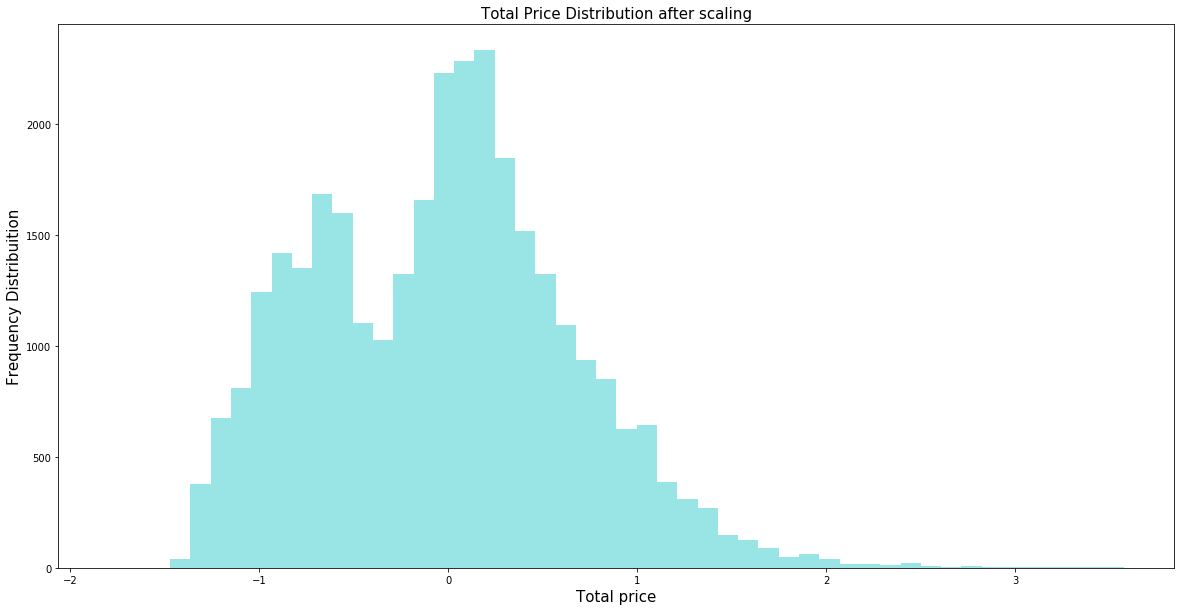

In [40]:
plt.figure(figsize=(20,10))
p = sns.distplot(robust_scaled_df['Total Price new'],color='c',kde=False)
p.set_title("Total Price Distribution after scaling", fontsize=15)
p.set_xlabel("Total price", fontsize=15)
p.set_ylabel("Frequency Distribuition", fontsize=15)

In [41]:
y=robust_scaled_df['Total Price new']
X=robust_scaled_df.drop(['Total Price new'],axis=1)

In [42]:
# dealing with categorical features
# for feature 'floor position' and 'House Remodelling' we believe the indices represents the feature in advance level, thus we keep the numerical indices as it is
# for feature 'distict', 'orientation' we get dummy variables for each categories of the features

district = pd.get_dummies(df_new['District new']).rename(columns=District_rev_dict)
orientation = pd.get_dummies(df_new['Orientation new']).rename(columns=orientation_rev_dict)

 
X1=np.concatenate((X.values,district.values,orientation.values),axis=1)

columns = list(X.columns.values)
new_columns = columns+list(district.columns.values)+list(orientation.columns.values)
X1 = pd.DataFrame(X1,columns=new_columns)

X1.shape, X.shape,district.shape,orientation.shape


((31602, 41), (31602, 13), (31602, 18), (31602, 10))

# Modelling

In [43]:
X1.shape,y.shape

((31602, 41), (31602,))

In [44]:
X1.head(10)

,Green Space Ratio,Usable Area new,Duration of Property Right new,Year of Construction new,Month-on-Month Growth Rate new,bedroom,dining,bathroom,House Remodeling new,floor position,...,东,东北,东南,东西,北,南,南北,西,西北,西南
0,0.627139,0.519348,0.0,0.071323,-0.170051,0.000000,0.000000,0.000000,0.279371,1.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.329865,1.706010,0.0,0.569740,-0.230964,0.346645,0.000000,0.810500,0.279371,-1.574768,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,-0.988065,-0.234152,0.0,-1.576777,-0.065990,0.000000,-2.574768,0.000000,-0.346645,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.391695,-0.075335,0.0,-0.500105,-0.269036,0.000000,-1.000000,0.000000,0.000000,1.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.202257,-0.340667,0.0,-1.576777,-0.307107,0.000000,-2.574768,0.000000,-0.346645,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5,0.000000,0.603567,0.0,-0.285593,0.482234,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6,0.136354,0.224327,0.0,-0.643264,0.307107,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7,0.000000,0.981955,0.0,-0.285593,0.482234,0.346645,0.000000,0.463854,0.000000,-1.574768,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
8,0.000000,-0.390113,0.0,-1.145283,-0.512690,0.000000,-1.000000,0.000000,0.000000,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9,0.000000,0.427723,0.0,0.285110,-0.527919,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [45]:
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.2, random_state=7) 

In [46]:
#Get the Baseline performance of 4 models, we use R2 and RMSE over ten folds as evaluation metrics
def GetBaselineScore(model,name):
    clf=model()
    kfold = KFold(n_splits=5, random_state=7)
    results = cross_val_score(clf, X_train, y_train, cv=kfold)
    print(name+" R2 Score: %.4f (%.4f)" % (results.mean(), results.std()))
    rmse= np.sqrt(-cross_val_score(clf, X_train, y_train, scoring="neg_mean_squared_error", cv = kfold))
    print(name+" rmse score: {:.4f} ({:.4f})\n".format(rmse.mean(), rmse.std()))

In [47]:
GetBaselineScore(LinearRegression,'Linear Regression')
GetBaselineScore(lgb.LGBMRegressor,'LightGBM Regressor')
GetBaselineScore(ExtraTreesRegressor,'ExtraTrees Regressor')
GetBaselineScore(KNeighborsRegressor,'KNN regressor')

Linear Regression R2 Score: 0.9107 (0.0023)
Linear Regression rmse score: 0.2053 (0.0012)

LightGBM Regressor R2 Score: 0.9491 (0.0025)
LightGBM Regressor rmse score: 0.1549 (0.0028)

ExtraTrees Regressor R2 Score: 0.9556 (0.0021)
ExtraTrees Regressor rmse score: 0.1456 (0.0027)

KNN regressor R2 Score: 0.9067 (0.0051)
KNN regressor rmse score: 0.2098 (0.0054)



### Linear Model Improvement - Multi-Layer Perceptron

In [ ]:
# Fit the three mlp models with splitted training and validation set
# compare the learning curve of loss and R2 scores between the three models
# define callback function to keep track of the loss and r2 score after each epoch

class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.r2s = []
        self.valr2s = []

    def on_epoch_end(self, batch, logs={}):
        self.r2s.append(logs.get('r2'))
        self.losses.append(logs.get('loss'))
        self.valr2s.append(logs.get('val_r2'))

# define customized metics r2 to calculate the R2 score
def r2(y_true, y_pred):
    residual = K.sum(K.square(y_true-y_pred)) 
    total = K.sum(K.square(y_true-K.mean(y_true)))
    r2_score = 1-residual/(total+K.epsilon())
    return r2_score

input_d = X_train.shape[1]

start = timer()

dim = input_d
def MLP_model1():
    model = Sequential([
        Dense(dim, input_dim=input_d),
        Activation('relu'),
        Dense(1)])
    model.compile(loss='mean_squared_error', optimizer='adam',metrics=[r2])
    return model

history1 = LossHistory()
MLP1 = MLP_model1()
MLP1.fit(X_train, y_train, epochs=20, batch_size=32, callbacks=[history1], validation_split=0.1)

end = timer()
print('Elapse time: {}'.format(end-start))

In [107]:
start = timer()
dim = input_d*2
def MLP_model2():
    model = Sequential([
        Dense(input_d*2, input_dim=input_d),
        Activation('relu'),
        Dense(1)])
    model.compile(loss='mean_squared_error', optimizer='adam',metrics=[r2])
    return model


        
#earlystop = EarlyStopping(monitor='r2', patience=2)
history2 = LossHistory()
MLP2 = MLP_model2()
MLP2.fit(X_train, y_train, epochs=20, batch_size=32, callbacks=[history2], validation_split=0.1)

end = timer()
print('Elapse time: {}'.format(end-start))



Train on 33930 samples, validate on 3771 samples
Epoch 1/20
33930/33930 [==============================] - 10s 307us/step - loss: 0.0590 - r2: 0.8628 - val_loss: 0.0308 - val_r2: 0.9269
Epoch 2/20
33930/33930 [==============================] - 5s 158us/step - loss: 0.0308 - r2: 0.9282 - val_loss: 0.0274 - val_r2: 0.9351
Epoch 3/20
33930/33930 [==============================] - 5s 150us/step - loss: 0.0280 - r2: 0.9347 - val_loss: 0.0281 - val_r2: 0.9333
Epoch 4/20
33930/33930 [==============================] - 5s 157us/step - loss: 0.0264 - r2: 0.9386 - val_loss: 0.0283 - val_r2: 0.9331
Epoch 5/20
33930/33930 [==============================] - 6s 165us/step - loss: 0.0254 - r2: 0.9410 - val_loss: 0.0247 - val_r2: 0.9415
Epoch 6/20
33930/33930 [==============================] - 6s 177us/step - loss: 0.0247 - r2: 0.9427 - val_loss: 0.0235 - val_r2: 0.9442
Epoch 7/20
33930/33930 [==============================] - 5s 152us/step - loss: 0.0241 - r2: 0.9440 - val_loss: 0.0248 - val_r2: 0.941

In [109]:
start = timer()
dim = input_d*3

def MLP_model3():
    model = Sequential([
        Dense(dim, input_dim=input_d),
        Activation('relu'),
        Dense(1)])
    model.compile(loss='mean_squared_error', optimizer='adam',metrics=[r2])
    return model


        
#earlystop = EarlyStopping(monitor='r2', patience=2)
history3 = LossHistory()
MLP3 = MLP_model3()
MLP3.fit(X_train, y_train, epochs=20, batch_size=32, callbacks=[history3], validation_split=0.1)
end = timer()

print('Elapse time: {}'.format(end-start))



Train on 33930 samples, validate on 3771 samples
Epoch 1/20
33930/33930 [==============================] - 10s 281us/step - loss: 0.0497 - r2: 0.8879 - val_loss: 0.0311 - val_r2: 0.9273
Epoch 2/20
33930/33930 [==============================] - 5s 138us/step - loss: 0.0287 - r2: 0.9330 - val_loss: 0.0263 - val_r2: 0.9380
Epoch 3/20
33930/33930 [==============================] - 5s 151us/step - loss: 0.0266 - r2: 0.9384 - val_loss: 0.0249 - val_r2: 0.9414
Epoch 4/20
33930/33930 [==============================] - 5s 159us/step - loss: 0.0251 - r2: 0.9415 - val_loss: 0.0237 - val_r2: 0.9440
Epoch 5/20
33930/33930 [==============================] - 6s 165us/step - loss: 0.0240 - r2: 0.9444 - val_loss: 0.0235 - val_r2: 0.9442
Epoch 6/20
33930/33930 [==============================] - 5s 158us/step - loss: 0.0231 - r2: 0.9464 - val_loss: 0.0238 - val_r2: 0.9433
Epoch 7/20
33930/33930 [==============================] - 5s 162us/step - loss: 0.0223 - r2: 0.9476 - val_loss: 0.0227 - val_r2: 0.946

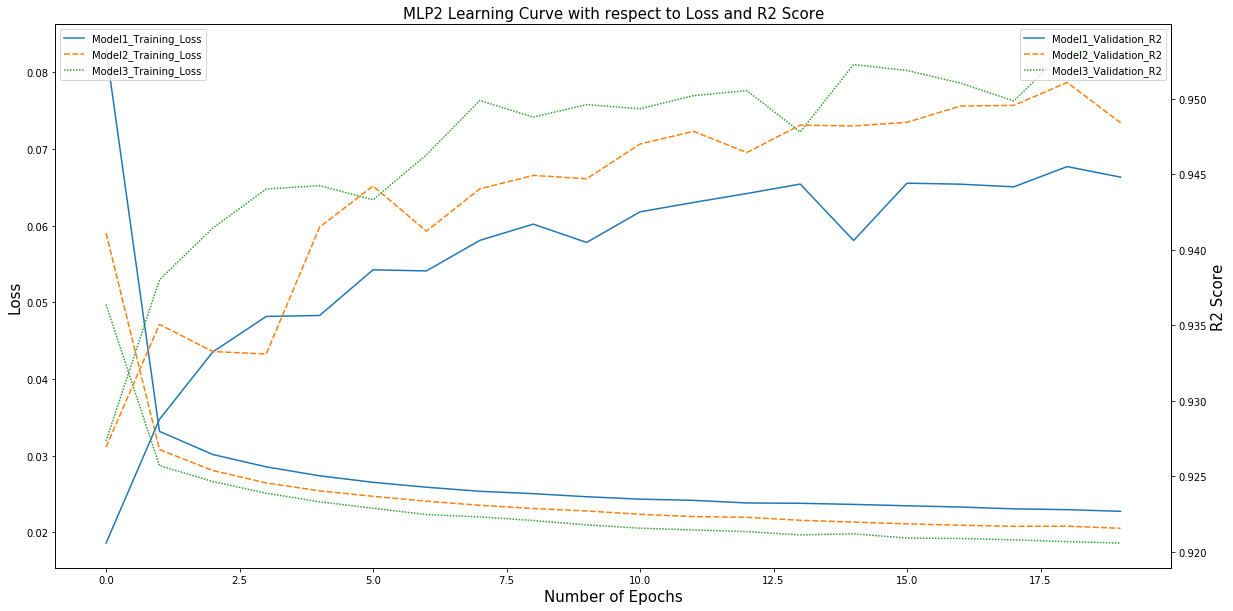

In [123]:
Loss_df1 = pd.DataFrame({'Model1_Training_Loss': history1.losses,
                       'Model2_Training_Loss': history2.losses,
                       'Model3_Training_Loss': history3.losses})
R2_df1 = pd.DataFrame({'Model1_Validation_R2': history1.valr2s,
                       'Model2_Validation_R2': history2.valr2s,
                      'Model3_Validation_R2': history3.valr2s})

plt.figure(figsize=(20,10))
p1 = sns.lineplot(data=Loss_df1, hue_order=['Model1_Training_Loss','Model2_Training_Loss','Model3_Training_Loss'], color = 'g')
ax2 = plt.twinx()
p3 = sns.lineplot(data=R2_df1, hue_order=['Model1_Validation_R2','Model2_Validation_R2','Model3_Validation_R2'], color="b", ax=ax2)
p1.set_title("MLP2 Learning Curve with respect to Loss and R2 Score", fontsize=15)
p1.set_xlabel("Number of Epochs", fontsize=15)
p1.set_ylabel("Loss", fontsize=15)
p3.set_ylabel("R2 Score", fontsize=15)
p3.legend(loc=1)
p1.legend(loc=2)



In [110]:
start = timer()
dim = (input_d*3)//2
def MLP_model4():
    model = Sequential([
        Dense(dim, input_dim=input_d),
        Activation('relu'),
        Dense(dim),
        Activation('relu'),
        Dense(1)])
    model.compile(loss='mean_squared_error', optimizer='adam',metrics=[r2])
    return model

       
#earlystop = EarlyStopping(monitor='r2', patience=2)
history4 = LossHistory()
MLP4 = MLP_model4()
MLP4.fit(X_train, y_train, epochs=20, batch_size=32, callbacks=[history4], validation_split=0.1)
end = timer()

print('Elapse time: {}'.format(end-start))

Train on 33930 samples, validate on 3771 samples
Epoch 1/20
33930/33930 [==============================] - 11s 319us/step - loss: 0.0499 - r2: 0.8866 - val_loss: 0.0296 - val_r2: 0.9303
Epoch 2/20
33930/33930 [==============================] - 6s 163us/step - loss: 0.0286 - r2: 0.9335 - val_loss: 0.0264 - val_r2: 0.9377
Epoch 3/20
33930/33930 [==============================] - 5s 158us/step - loss: 0.0263 - r2: 0.9389 - val_loss: 0.0248 - val_r2: 0.9414
Epoch 4/20
33930/33930 [==============================] - 6s 166us/step - loss: 0.0247 - r2: 0.9424 - val_loss: 0.0241 - val_r2: 0.9430
Epoch 5/20
33930/33930 [==============================] - 7s 201us/step - loss: 0.0233 - r2: 0.9457 - val_loss: 0.0228 - val_r2: 0.9460
Epoch 6/20
33930/33930 [==============================] - 6s 181us/step - loss: 0.0225 - r2: 0.9475 - val_loss: 0.0222 - val_r2: 0.9475
Epoch 7/20
33930/33930 [==============================] - 6s 170us/step - loss: 0.0215 - r2: 0.9497 - val_loss: 0.0218 - val_r2: 0.948

In [111]:
start = timer()
dim = input_d
def MLP_model5():
    model = Sequential([
        Dense(dim, input_dim=input_d),
        Activation('relu'),
        Dense(dim),
        Activation('relu'),
        Dense(dim),
        Activation('relu'),
        Dense(1)])
    model.compile(loss='mean_squared_error', optimizer='adam',metrics=[r2])
    return model

history5 = LossHistory()
MLP5 = MLP_model5()
MLP5.fit(X_train, y_train, epochs=20, batch_size=32, callbacks=[history5], validation_split=0.1)

end = timer()
print('Elapse time: {}'.format(end-start))


Train on 33930 samples, validate on 3771 samples
Epoch 1/20
33930/33930 [==============================] - 10s 302us/step - loss: 0.0540 - r2: 0.8765 - val_loss: 0.0307 - val_r2: 0.9276
Epoch 2/20
33930/33930 [==============================] - 7s 211us/step - loss: 0.0296 - r2: 0.9315 - val_loss: 0.0276 - val_r2: 0.9352
Epoch 3/20
33930/33930 [==============================] - 6s 180us/step - loss: 0.0268 - r2: 0.9378 - val_loss: 0.0314 - val_r2: 0.9266
Epoch 4/20
33930/33930 [==============================] - 6s 182us/step - loss: 0.0252 - r2: 0.9413 - val_loss: 0.0252 - val_r2: 0.9410
Epoch 5/20
33930/33930 [==============================] - 6s 176us/step - loss: 0.0238 - r2: 0.9447 - val_loss: 0.0233 - val_r2: 0.9451
Epoch 6/20
33930/33930 [==============================] - 6s 166us/step - loss: 0.0232 - r2: 0.9463 - val_loss: 0.0219 - val_r2: 0.9482
Epoch 7/20
33930/33930 [==============================] - 6s 172us/step - loss: 0.0224 - r2: 0.9481 - val_loss: 0.0218 - val_r2: 0.948

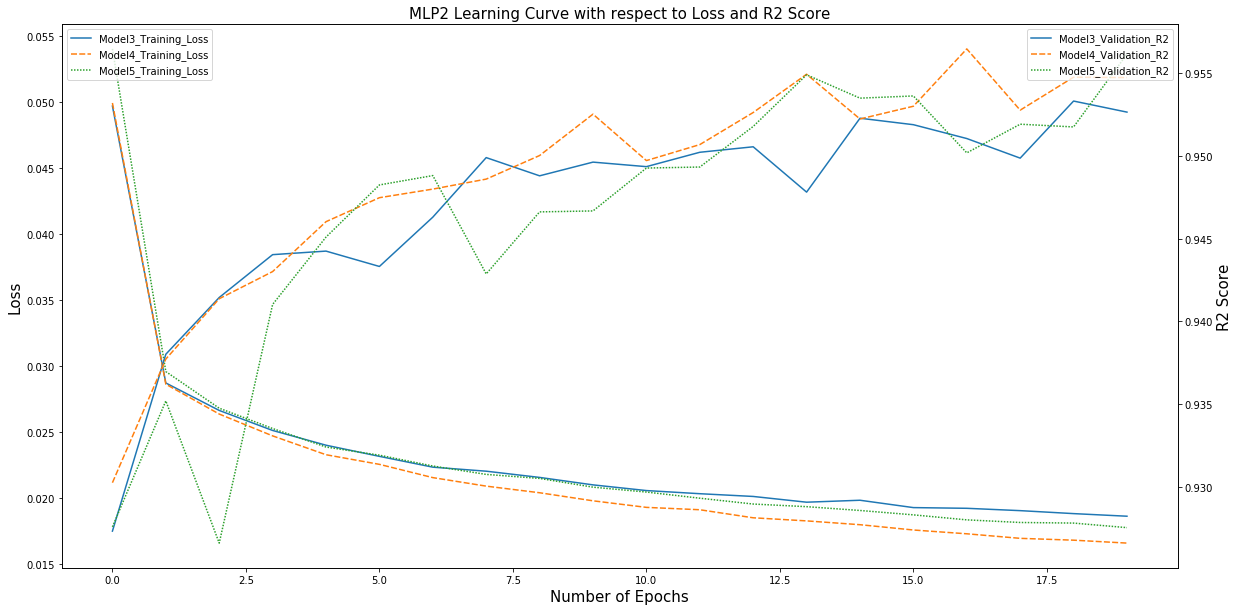

In [124]:
Loss_df2 = pd.DataFrame({'Model3_Training_Loss': history3.losses,
                       'Model4_Training_Loss': history4.losses,
                       'Model5_Training_Loss': history5.losses})
R2_df2 = pd.DataFrame({'Model3_Validation_R2': history3.valr2s,
                       'Model4_Validation_R2': history4.valr2s,
                      'Model5_Validation_R2': history5.valr2s})

plt.figure(figsize=(20,10))
p1 = sns.lineplot(data=Loss_df2, hue_order=['Model3_Training_Loss','Model4_Training_Loss','Model5_Training_Loss'], color = 'g')
ax2 = plt.twinx()
p3 = sns.lineplot(data=R2_df2, hue_order=['Model3_Validation_R2','Model4_Validation_R2','Model5_Validation_R2'], color="b", ax=ax2)
p1.set_title("MLP2 Learning Curve with respect to Loss and R2 Score", fontsize=15)
p1.set_xlabel("Number of Epochs", fontsize=15)
p1.set_ylabel("Loss", fontsize=15)
p3.set_ylabel("R2 Score", fontsize=15)
p3.legend(loc=1)
p1.legend(loc=2)



In [132]:
#Utility Function to report best outcomes
def report(results, n_top=10):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3hf} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
            
def sort_dict(input_dict):
    X = []
    y = []
    for key, value in sorted(input_dict.items()):
        X.append(key)
        y.append(value)
    return X, y

In [136]:
#Perform Randomized Search on ExtraTree
clf_Ext = ExtraTreesRegressor()
param_dist = {'n_estimators': [10,20,30,40,50,60,70,80,90,100,200], #PARA1
              'max_depth':[None,3,4,5,6,7,8,9,10,20,30,40,50], #PARA2
              'bootstrap':[True, False]
             }

n_iter_search = 50
random_search = RandomizedSearchCV(clf_Ext, 
                         param_distributions = param_dist,
                         cv = 5,     
                         verbose = 0, 
                         n_jobs = -1,
                         n_iter=n_iter_search)
start = time()
random_search.fit(X_train, y_train)
print("RandomSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)

RandomSearchCV took 308.87 seconds for 50 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.961 (std: 0.002)
Parameters: {'n_estimators': 80, 'max_depth': 50, 'bootstrap': False}

Model with rank: 2
Mean validation score: 0.961 (std: 0.002)
Parameters: {'n_estimators': 100, 'max_depth': None, 'bootstrap': False}

Model with rank: 3
Mean validation score: 0.961 (std: 0.002)
Parameters: {'n_estimators': 90, 'max_depth': None, 'bootstrap': False}

Model with rank: 4
Mean validation score: 0.961 (std: 0.002)
Parameters: {'n_estimators': 70, 'max_depth': 50, 'bootstrap': False}

Model with rank: 5
Mean validation score: 0.960 (std: 0.002)
Parameters: {'n_estimators': 70, 'max_depth': 30, 'bootstrap': False}

Model with rank: 6
Mean validation score: 0.960 (std: 0.002)
Parameters: {'n_estimators': 50, 'max_depth': None, 'bootstrap': False}

Model with rank: 7
Mean validation score: 0.959 (std: 0.002)
Parameters: {'n_estimators': 200, 'max_depth': 30, 'bootstrap': Tru

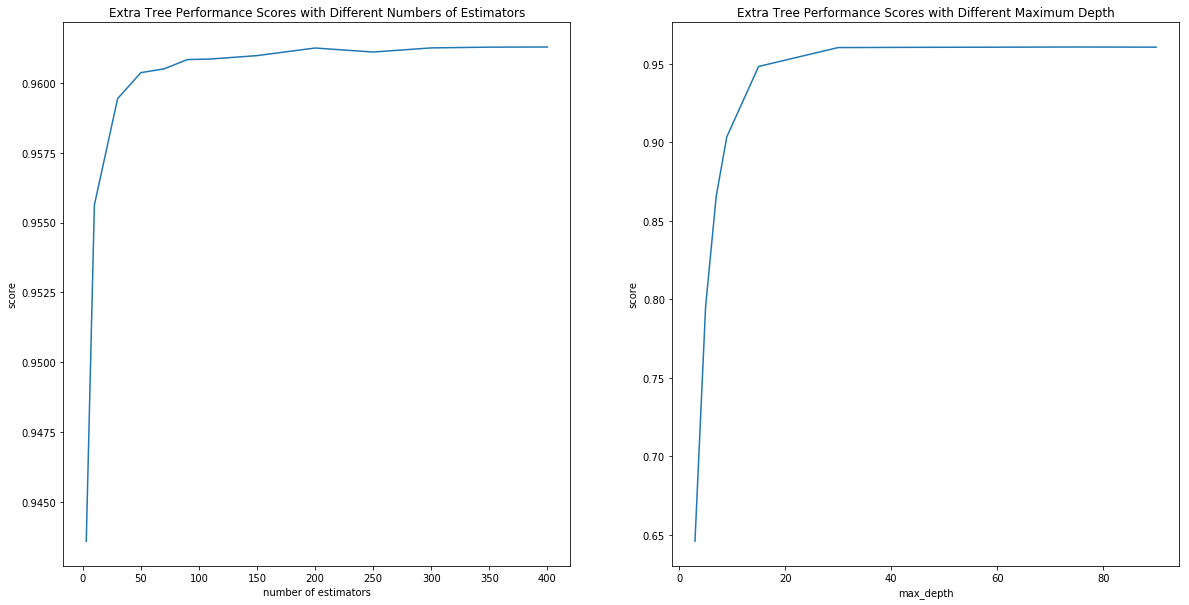

In [56]:
def GetScore(model):
    kfold = KFold(n_splits=5, random_state=7)
    results = cross_val_score(model, X_train, y_train, cv=kfold)
    return results.mean()

n_estimators=[3,10,30,50,70,90,110,150,200,250,300,350,400]
max_depth=[3,5,7,9,15,30,45,60,75,90]
score1=[]
score2=[]
for i in n_estimators:
    score1.append(GetScore(ExtraTreesRegressor(n_estimators=i,max_depth=50,bootstrap=False)))
for i in max_depth:
    score2.append(GetScore(ExtraTreesRegressor(n_estimators=80,max_depth=i,bootstrap=False)))

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.xlabel('number of estimators')
plt.ylabel('score')
plt.title('Extra Tree Performance Scores with Different Numbers of Estimators')
plt.plot(n_estimators, score1)

p = plt.subplot(1,2,2)
plt.plot(max_depth, score2)
plt.xlabel('max_depth')
plt.ylabel('score')
plt.title('Extra Tree Performance Scores with Different Maximum Depth')
plt.show()

In [139]:
#Perform Randomized Search on LightGBM with selected number of estimators
clf_lgb = lgb.LGBMRegressor()
param_dist = {'n_estimators': [750, 800, 850, 900, 950],
              'learning_rate': [0.001,0.005,0.01,0.05,0.1,0.2,0.3,0.4,0.5],
              'max_depth': [-1,1,2,4,5,6,7,8,9,10,15,20,30,50,70,100,200],
              'colsample_bytree': [0.7,0.8,0.9,1],
              'subsample': [0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
             }

n_iter_search = 50
random_search = RandomizedSearchCV(clf_lgb, 
                         param_distributions = param_dist,
                         cv = 5, 
                         verbose = 0, 
                         n_jobs = -1,
                         n_iter=n_iter_search)
start = time()
random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)

RandomizedSearchCV took 277.69 seconds for 50 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.967 (std: 0.002)
Parameters: {'subsample': 0.3, 'n_estimators': 950, 'max_depth': -1, 'learning_rate': 0.1, 'colsample_bytree': 0.7}

Model with rank: 1
Mean validation score: 0.967 (std: 0.002)
Parameters: {'subsample': 0.4, 'n_estimators': 950, 'max_depth': -1, 'learning_rate': 0.1, 'colsample_bytree': 0.7}

Model with rank: 1
Mean validation score: 0.967 (std: 0.002)
Parameters: {'subsample': 0.5, 'n_estimators': 950, 'max_depth': -1, 'learning_rate': 0.1, 'colsample_bytree': 0.7}

Model with rank: 1
Mean validation score: 0.967 (std: 0.002)
Parameters: {'subsample': 0.6, 'n_estimators': 950, 'max_depth': -1, 'learning_rate': 0.1, 'colsample_bytree': 0.7}

Model with rank: 1
Mean validation score: 0.967 (std: 0.002)
Parameters: {'subsample': 0.7, 'n_estimators': 950, 'max_depth': -1, 'learning_rate': 0.1, 'colsample_bytree': 0.7}

Model with rank: 6
Mean validatio

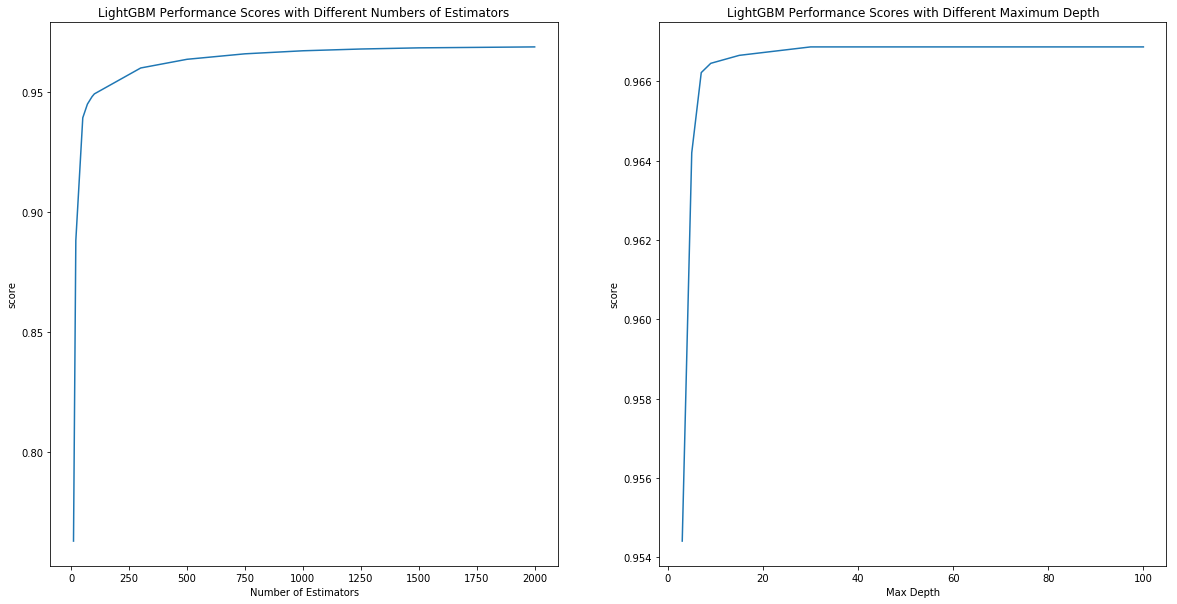

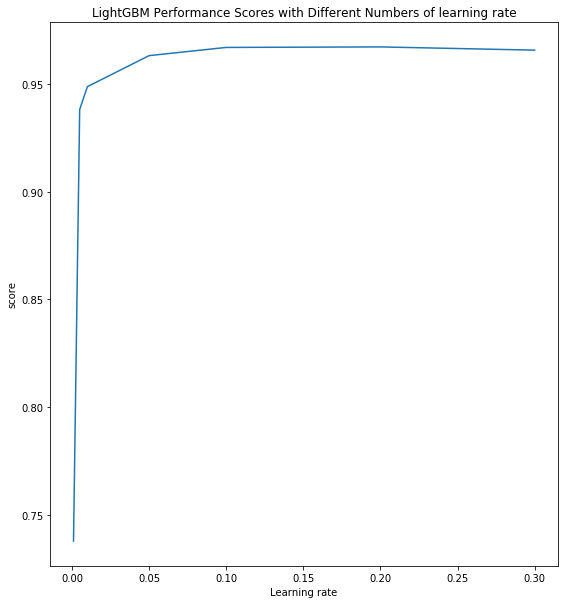

In [57]:
n_estimators=[10,20,50,70,90,100,300,500,750,1000,1250,1500,2000]
max_depth=[3,5,7,9,15,30,45,60,85,100]
learning_rate=[0.001,0.005,0.01,0.05,0.1,0.2,0.3]
score1=[]
score2=[]
score3=[]
for i in n_estimators:
    score1.append(GetScore(lgb.LGBMRegressor(n_estimators=i,max_depth=-1,learning_rate=0.1,bootstrap=False)))
for i in max_depth:
    score2.append(GetScore(lgb.LGBMRegressor(n_estimators=950,max_depth=i,learning_rate=0.1,bootstrap=False)))
for i in learning_rate:
    score3.append(GetScore(lgb.LGBMRegressor(n_estimators=950,max_depth=-1,learning_rate=i,bootstrap=False)))


plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.xlabel('Number of Estimators')
plt.ylabel('score')
plt.title('LightGBM Performance Scores with Different Numbers of Estimators')
plt.plot(n_estimators, score1)

p = plt.subplot(1,2,2)
plt.plot(max_depth, score2)
plt.xlabel('Max Depth')
plt.ylabel('score')
plt.title('LightGBM Performance Scores with Different Maximum Depth')
plt.show()

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.xlabel('Learning rate')
plt.ylabel('score')
plt.title('LightGBM Performance Scores with Different Numbers of learning rate')
plt.plot(learning_rate, score3)


In [109]:
#Perform Randomized Search on KNN
clf_knn = KNeighborsRegressor()
param_dist = {'n_neighbors':[6,7,8,9,10,11,12,13,14,15],
              'p':[1,2,3,4,5]
             }

n_iter_search = 20
random_search = RandomizedSearchCV(clf_knn, 
                         param_distributions = param_dist,
                         cv = 5,     
                         verbose = 0, 
                         n_jobs = -1,
                         n_iter=n_iter_search)
start = time()
random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)

RandomizedSearchCV took 1771.88 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.917 (std: 0.005)
Parameters: {'p': 1, 'n_neighbors': 8}

Model with rank: 2
Mean validation score: 0.912 (std: 0.005)
Parameters: {'p': 1, 'n_neighbors': 12}

Model with rank: 3
Mean validation score: 0.911 (std: 0.005)
Parameters: {'p': 1, 'n_neighbors': 13}

Model with rank: 4
Mean validation score: 0.910 (std: 0.005)
Parameters: {'p': 1, 'n_neighbors': 14}

Model with rank: 5
Mean validation score: 0.904 (std: 0.005)
Parameters: {'p': 2, 'n_neighbors': 8}

Model with rank: 6
Mean validation score: 0.903 (std: 0.006)
Parameters: {'p': 2, 'n_neighbors': 9}

Model with rank: 7
Mean validation score: 0.900 (std: 0.006)
Parameters: {'p': 2, 'n_neighbors': 11}

Model with rank: 8
Mean validation score: 0.899 (std: 0.006)
Parameters: {'p': 2, 'n_neighbors': 12}

Model with rank: 9
Mean validation score: 0.897 (std: 0.006)
Parameters: {'p': 2, 'n_neighbors': 13}

Model w

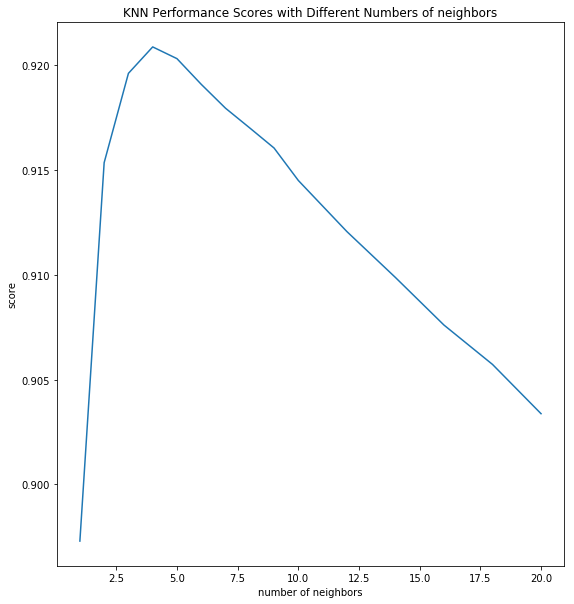

In [58]:
n_neighbors=[1,2,3,4,5,6,7,8,9,10,12,14,16,18,20]
score1=[]

for i in n_neighbors:
    score1.append(GetScore(KNeighborsRegressor(n_neighbors=i,p=1)))

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.xlabel('number of neighbors')
plt.ylabel('score')
plt.title('KNN Performance Scores with Different Numbers of neighbors')
plt.plot(n_neighbors, score1)


In [69]:
#Check the final performance of models
def GetFinalScore(clf,name):
    kfold = KFold(n_splits=10, random_state=7)
    results = cross_val_score(clf, X_train, y_train, cv=kfold)
    print(name+" R2 Score: %.4f (%.4f)" % (results.mean(), results.std()))
    rmse= np.sqrt(-cross_val_score(clf, X_train, y_train, scoring="neg_mean_squared_error", cv = kfold))
    print(name+" rmse score: {:.4f} ({:.4f})\n".format(rmse.mean(), rmse.std()))

In [73]:
clf1=lgb.LGBMRegressor(colsample_bytree=0.8, learning_rate=0.1, max_depth=30, n_estimators=1500, subsample=0.7)
clf2=ExtraTreesRegressor(bootstrap= False, max_depth= 40, n_estimators= 200)
clf3=KNeighborsRegressor(p=1,n_neighbors=4)

In [74]:
GetFinalScore(clf1,'LightGBM')
GetFinalScore(clf2,'Extra Tree Regressor')
GetFinalScore(clf3,'KNN Regressor')

LightGBM R2 Score: 0.9689 (0.0027)
LightGBM rmse score: 0.1209 (0.0053)

Extra Tree Regressor R2 Score: 0.9627 (0.0027)
Extra Tree Regressor rmse score: 0.1329 (0.0054)

KNN Regressor R2 Score: 0.9233 (0.0058)
KNN Regressor rmse score: 0.1900 (0.0069)



### Compared to the baseline performance

Linear Regression R2 Score: 0.9107 (0.0023)
Linear Regression rmse score: 0.2053 (0.0012)

LightGBM Regressor R2 Score: 0.9491 (0.0025)
LightGBM Regressor rmse score: 0.1549 (0.0028)

ExtraTrees Regressor R2 Score: 0.9556 (0.0021)
ExtraTrees Regressor rmse score: 0.1456 (0.0027)

KNN regressor R2 Score: 0.9067 (0.0051)
KNN regressor rmse score: 0.2098 (0.0054)



In [78]:
#Create a average model to combine the prediction of top 3 models after tuning
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    
    def __init__(self, models):
        self.models = models
        
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        for model in self.models_:
            model.fit(X, y)
        return self
    
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)

In [82]:

# Evaluate the average model's performance
def r2(y_true, y_pred):
    residual = K.sum(K.square(y_true-y_pred)) 
    total = K.sum(K.square(y_true-K.mean(y_true)))
    r2_score = 1-residual/(total+K.epsilon())
    return r2_score
input_d = X_train.shape[1]
dim = input_d*3
def MLP_model3():
    model = Sequential([
        Dense(dim, input_dim=input_d),
        Activation('relu'),
        Dense(1)])
    model.compile(loss='mean_squared_error', optimizer='adam',metrics=[r2])
    return model
clf5 = KerasRegressor(build_fn=MLP_model3, epochs=20, batch_size=32, verbose=0)
averaged_models = AveragingModels(models = (clf1, clf2, clf3, clf5))
averaged_models.fit(X_train,y_train)
Prediction=averaged_models.predict(X_test)

In [83]:
print('Average model test set R2 Score:{}'.format(r2_score(y_test,Prediction)))
print('Average model test set RMSE Score:{}'.format(np.sqrt(mean_squared_error(y_test, Prediction))))
print('Average model test set explained_variance_score:{}'.format(explained_variance_score(y_test, Prediction)))

Average model test set R2 Score:0.9657954232042204
Average model test set RMSE Score:0.1250091886145994
Average model test set explained_variance_score:0.965857482395414


#  Feature Importance

In [76]:
# Getting feature importance for our best model
clf1.fit(X_train, y_train)
feature_importance = clf1.feature_importances_
feature_name = []
feature_importances = []
for i in range(21,1,-1):
    feature_name.append(X1.columns[np.argsort(feature_importance)[-i]])
    feature_importances.append(feature_importance[np.argsort(feature_importance)[-i]])
    print(X1.columns[np.argsort(feature_importance)[-i]], feature_importance[np.argsort(feature_importance)[-i]])

金山 234
闵行 257
普陀 272
宝山 283
嘉定 313
浦东 317
奉贤 336
南北 466
bathroom 478
南 520
dining 705
House Remodeling new 778
bedroom 877
floor position 927
total floor 3318
Green Space Ratio 3507
Floor Area Ratio 4096
Year of Construction new 4824
Property Management Fee new 5241
Usable Area new 7358


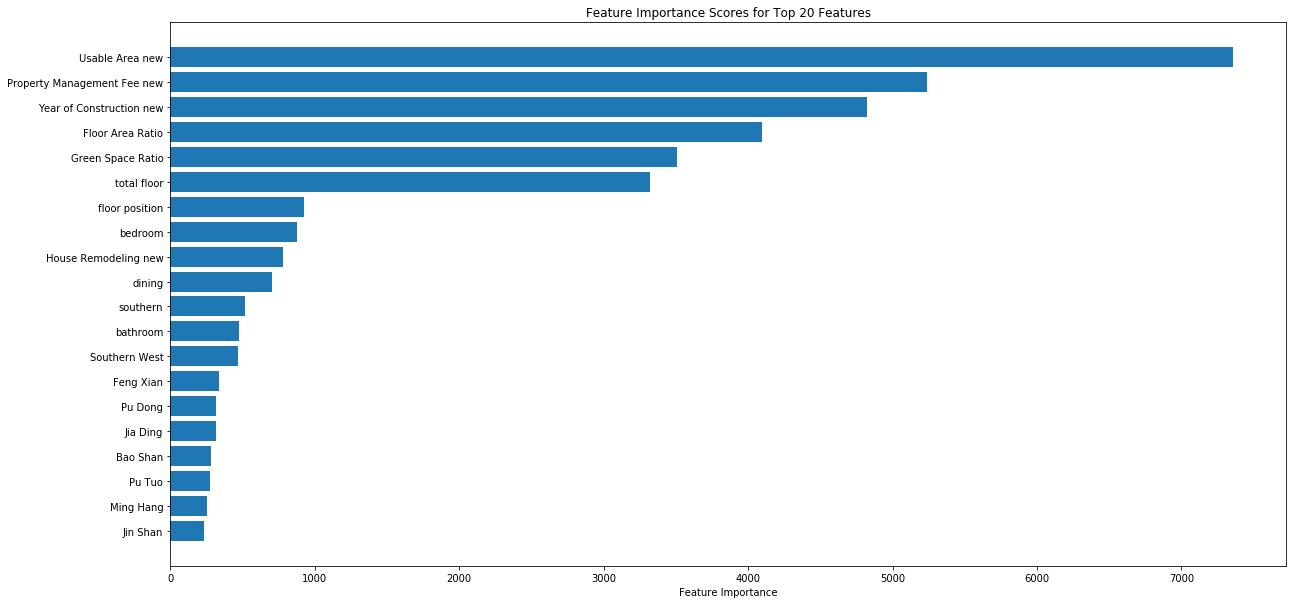

In [77]:
feature_name[0] = 'Jin Shan'
feature_name[1] = 'Ming Hang'
feature_name[2] = 'Pu Tuo'
feature_name[3] = 'Bao Shan'
feature_name[4] = 'Jia Ding'
feature_name[5] = 'Pu Dong'
feature_name[6] = 'Feng Xian'
feature_name[7] = 'Southern West'
feature_name[9] = 'southern'

plt.figure(figsize=(20,10))
y_pos = np.arange(len(feature_name))
plt.barh(feature_name, feature_importances, align='center')
plt.xlabel('Feature Importance')
plt.title('Feature Importance Scores for Top 20 Features')
plt.show()